Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

## DISCLAIMER. This book is probably useless apart from warming up dplyr/ggplot skills.

All sources are in R_sources/house_price/ folder.

In [15]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

# load sources
house_prices <- source('main.R', local = TRUE)$value

# load data
combinedData <- house_prices$helpers$load_data()

# dimensions check
c(
    combinedData %>% dim %>% show_list.html("combined"),
    combinedData %>% filter(dataSource == "train") %>% dim %>% show_list.html("train"),
    combinedData %>% filter(dataSource == "test") %>% dim %>% show_list.html("test")
) %>% paste0(collapse='') %>% display_html

attr_sel <- house_prices$attributes_selection

combined 2919 82 train 1460 82 test 1459 82

In [14]:
categColnames <- house_prices$helpers$get_character_colnames(combinedData)
numerColnames <- house_prices$helpers$get_numeric_colnames(combinedData)

categColnames %>% show_list("Categorical variables")
numerColnames %>% show_list("Numeric variables")

(44 elems) Categorical predictors Alley BldgType BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual CentralAir Condition1 Condition2 Electrical ExterCond Exterior1st Exterior2nd ExterQual Fence FireplaceQu Foundation Functional GarageCond GarageFinish GarageQual GarageType Heating HeatingQC HouseStyle KitchenQual LandContour LandSlope LotConfig LotShape MasVnrType MiscFeature MSSubClass MSZoning Neighborhood PavedDrive PoolQC RoofMatl RoofStyle SaleCondition SaleType Street Utilities

(37 elems) Numeric predictors BedroomAbvGr BsmtFinSF1 BsmtFinSF2 BsmtFullBath BsmtHalfBath BsmtUnfSF EnclosedPorch Fireplaces FullBath GarageArea GarageCars GarageYrBlt GrLivArea HalfBath KitchenAbvGr LotArea LotFrontage LowQualFinSF MasVnrArea MiscVal MoSold OpenPorchSF OverallCond OverallQual PoolArea price_log SalePrice ScreenPorch TotalBsmtSF TotRmsAbvGrd WoodDeckSF X1stFlrSF X2ndFlrSF X3SsnPorch YearBuilt YearRemodAdd YrSold

In [18]:
categData <- 
    combinedData %>% 
    select(house_prices$helpers$get_character_colnames(combinedData), SalePrice, Id)

numerData <- 
    combinedData %>% 
    select(house_prices$helpers$get_numeric_colnames(combinedData), Id)

c(
    categData %>% dim %>% show_list.html("categ"),
    numerData %>% dim %>% show_list.html("numer")
) %>% paste0(collapse='') %>% display_html

categ 2919 46 numer 2919 37

# "Normal Paper" applied to SalePrice

var value normed_value 
 
 price 755000.00000 7.226343 
 price_log 13.53447 3.781237 
 
 

 
 
 
 
 
 
 
 var L2 x y lab 
 
 price 7.46 0 5 L2 = 7.46 
 price_log 0.65 0 5 L2 = 0.65

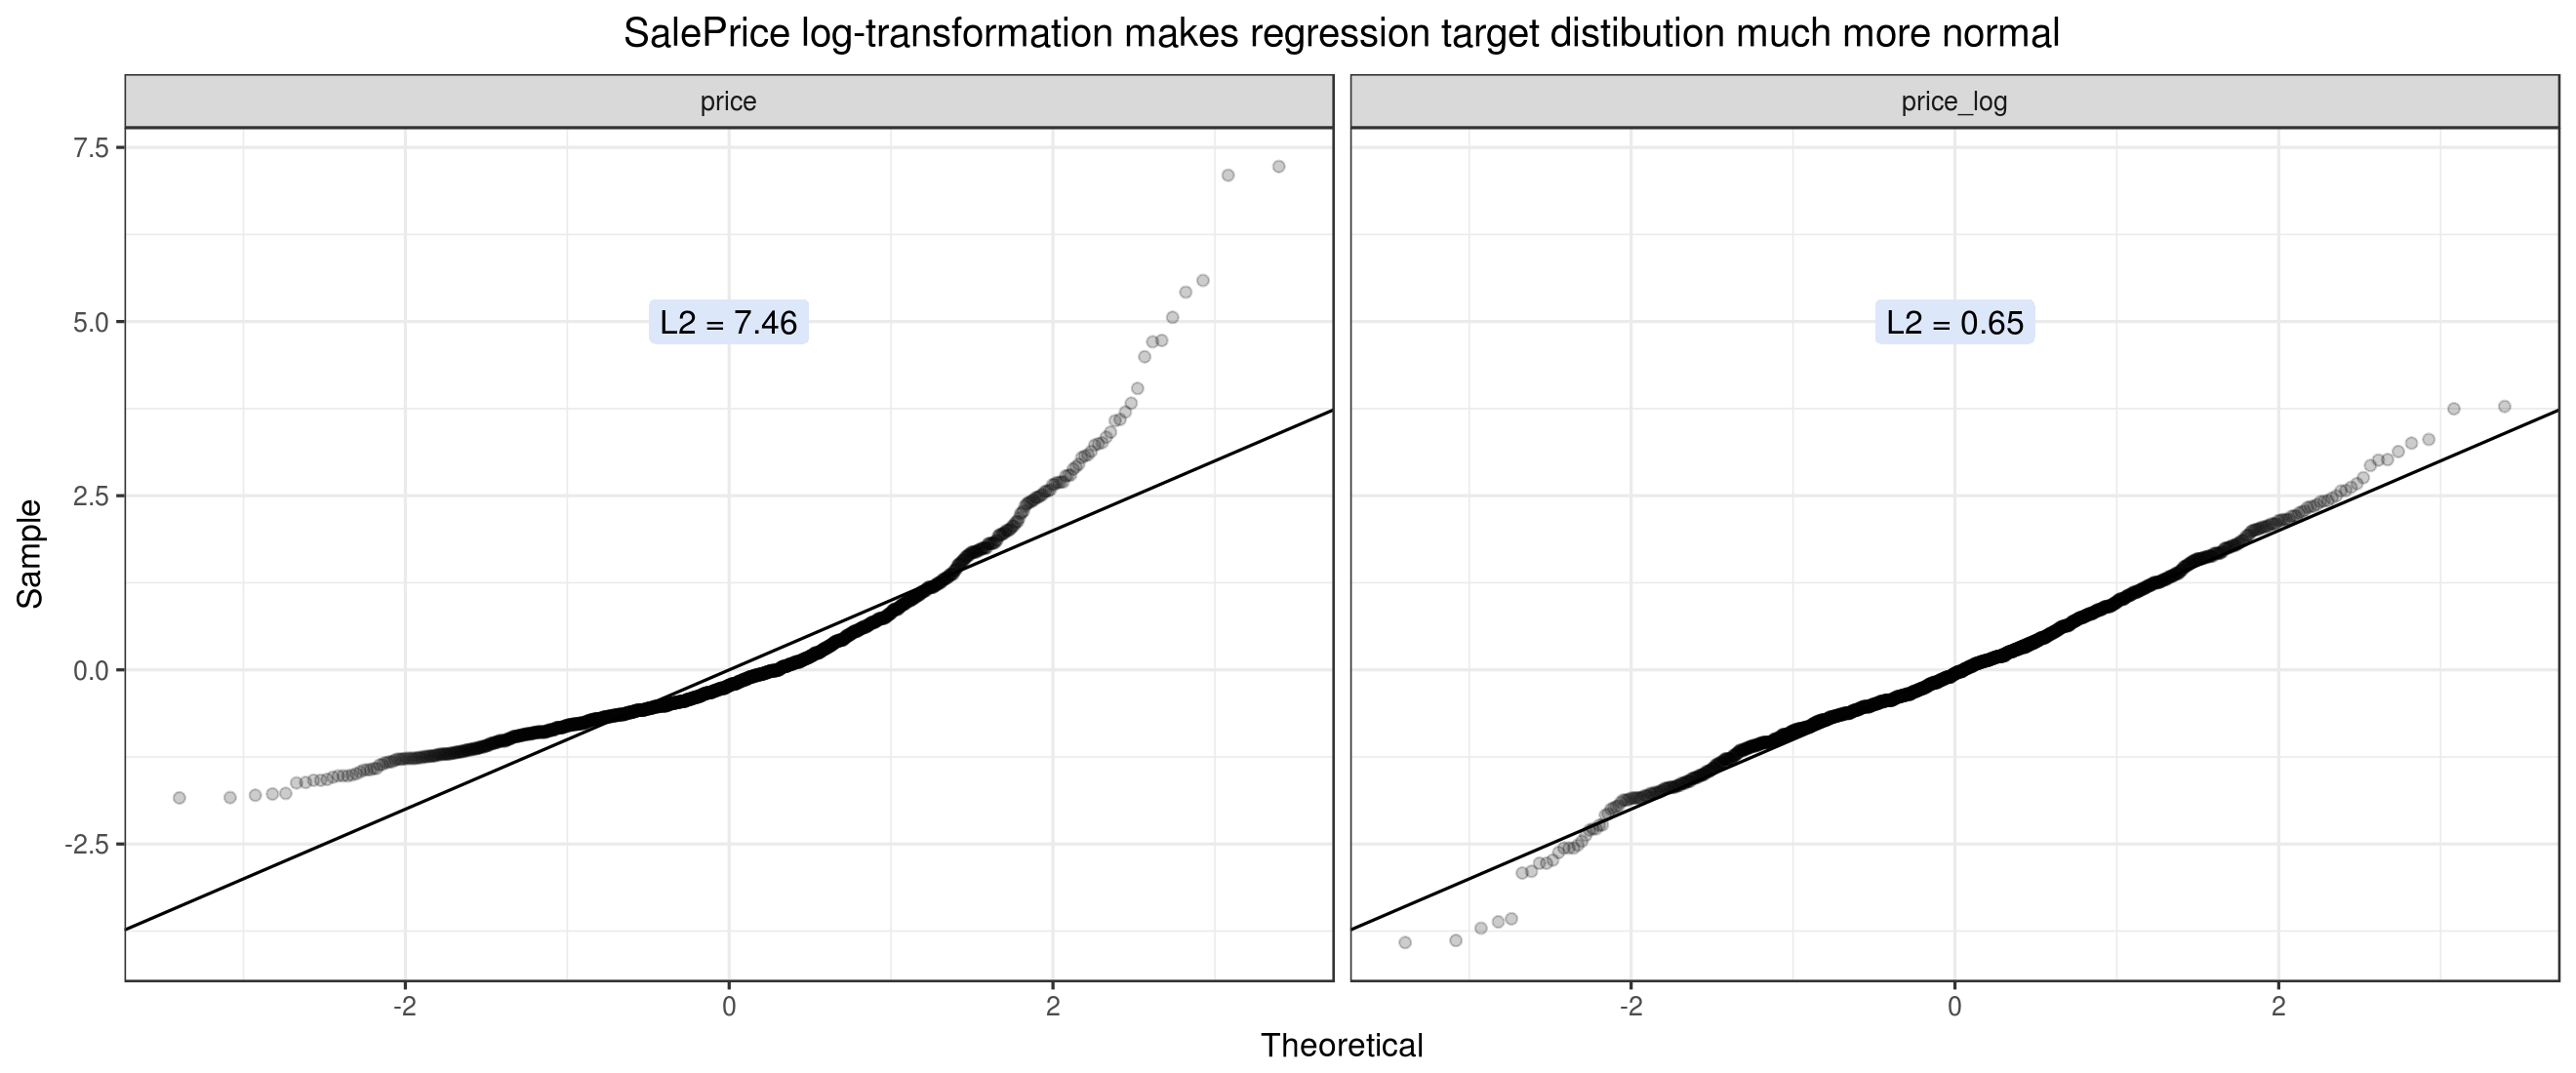

In [17]:
target_normal_paper <-
    combinedData %>% 
    select(price=SalePrice) %>% 
    na.omit %>%
    mutate(
        price_log = log(price)
    ) %>%
    gather(var, value) %>%
    group_by(var) %>%
    mutate(
        normed_value = (value - mean(value)) / sd(value)
    )

# Deviation from theoretical normal distribution in terms of L2 norm
L2_labels <-
    target_normal_paper %>%
    select(-value) %>%
    group_by(var, normed_value) %>%
    summarise(
        k = n()
    ) %>%
    arrange(var, normed_value) %>%
    group_by(var) %>%
    mutate(
        empirical = cumsum(k) / sum(k),
        theoretical = pnorm(normed_value),
        L2_delta = k*(empirical - theoretical)**2
    ) %>% 
    summarise(
        L2 = round(sum(L2_delta), 2)
    ) %>% 
    mutate(x=0, y=5, lab=paste0('L2 = ', L2))

           
show_table(
    target_normal_paper %>% arrange(var, value) %>% top_n(1, value), 
    L2_labels    
)


`@@@`(12, 5, 220)
target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
ylab("Sample") + xlab("Theoretical") +
labs(
    title = "SalePrice log-transformation makes regression target distibution much more normal"
) +
geom_text(aes(x, y, label=lab), data=L2_labels) + 
geom_label(aes(x, y, label=lab), data=L2_labels, fill='#dde7fa', label.size=0)

In [5]:
# alternative L2 calculation
target_normal_paper %>%
select(-value) %>%
group_by(var) %>%
nest %>%
mutate(
    L2 = map_dbl(data, function(data) {
        nval <- sort(data[['normed_value']])
        cdf <- ecdf(nval)
        empir <- cdf(nval)
        theor <- pnorm(nval)
        round(sum((empir - theor)**2), 2)
    })
) %>%
select(-data)

var,L2
price,7.46
price_log,0.65


# Entropy of attribute distributions

Zero entropy means constant distibution of a factor and thus it's zero predictive power. So maybe entropy means something... or not.

var,entropy,type
TotalBsmtSF,9.348757,Numeric
BsmtUnfSF,9.390885,Numeric
X1stFlrSF,9.601608,Numeric
GrLivArea,9.882939,Numeric
LotArea,10.400602,Numeric
var,entropy,type
Utilities,0.01262749,Categorical
PoolQC,0.03820308,Categorical
Street,0.03850369,Categorical
PoolArea,0.05767714,Numeric


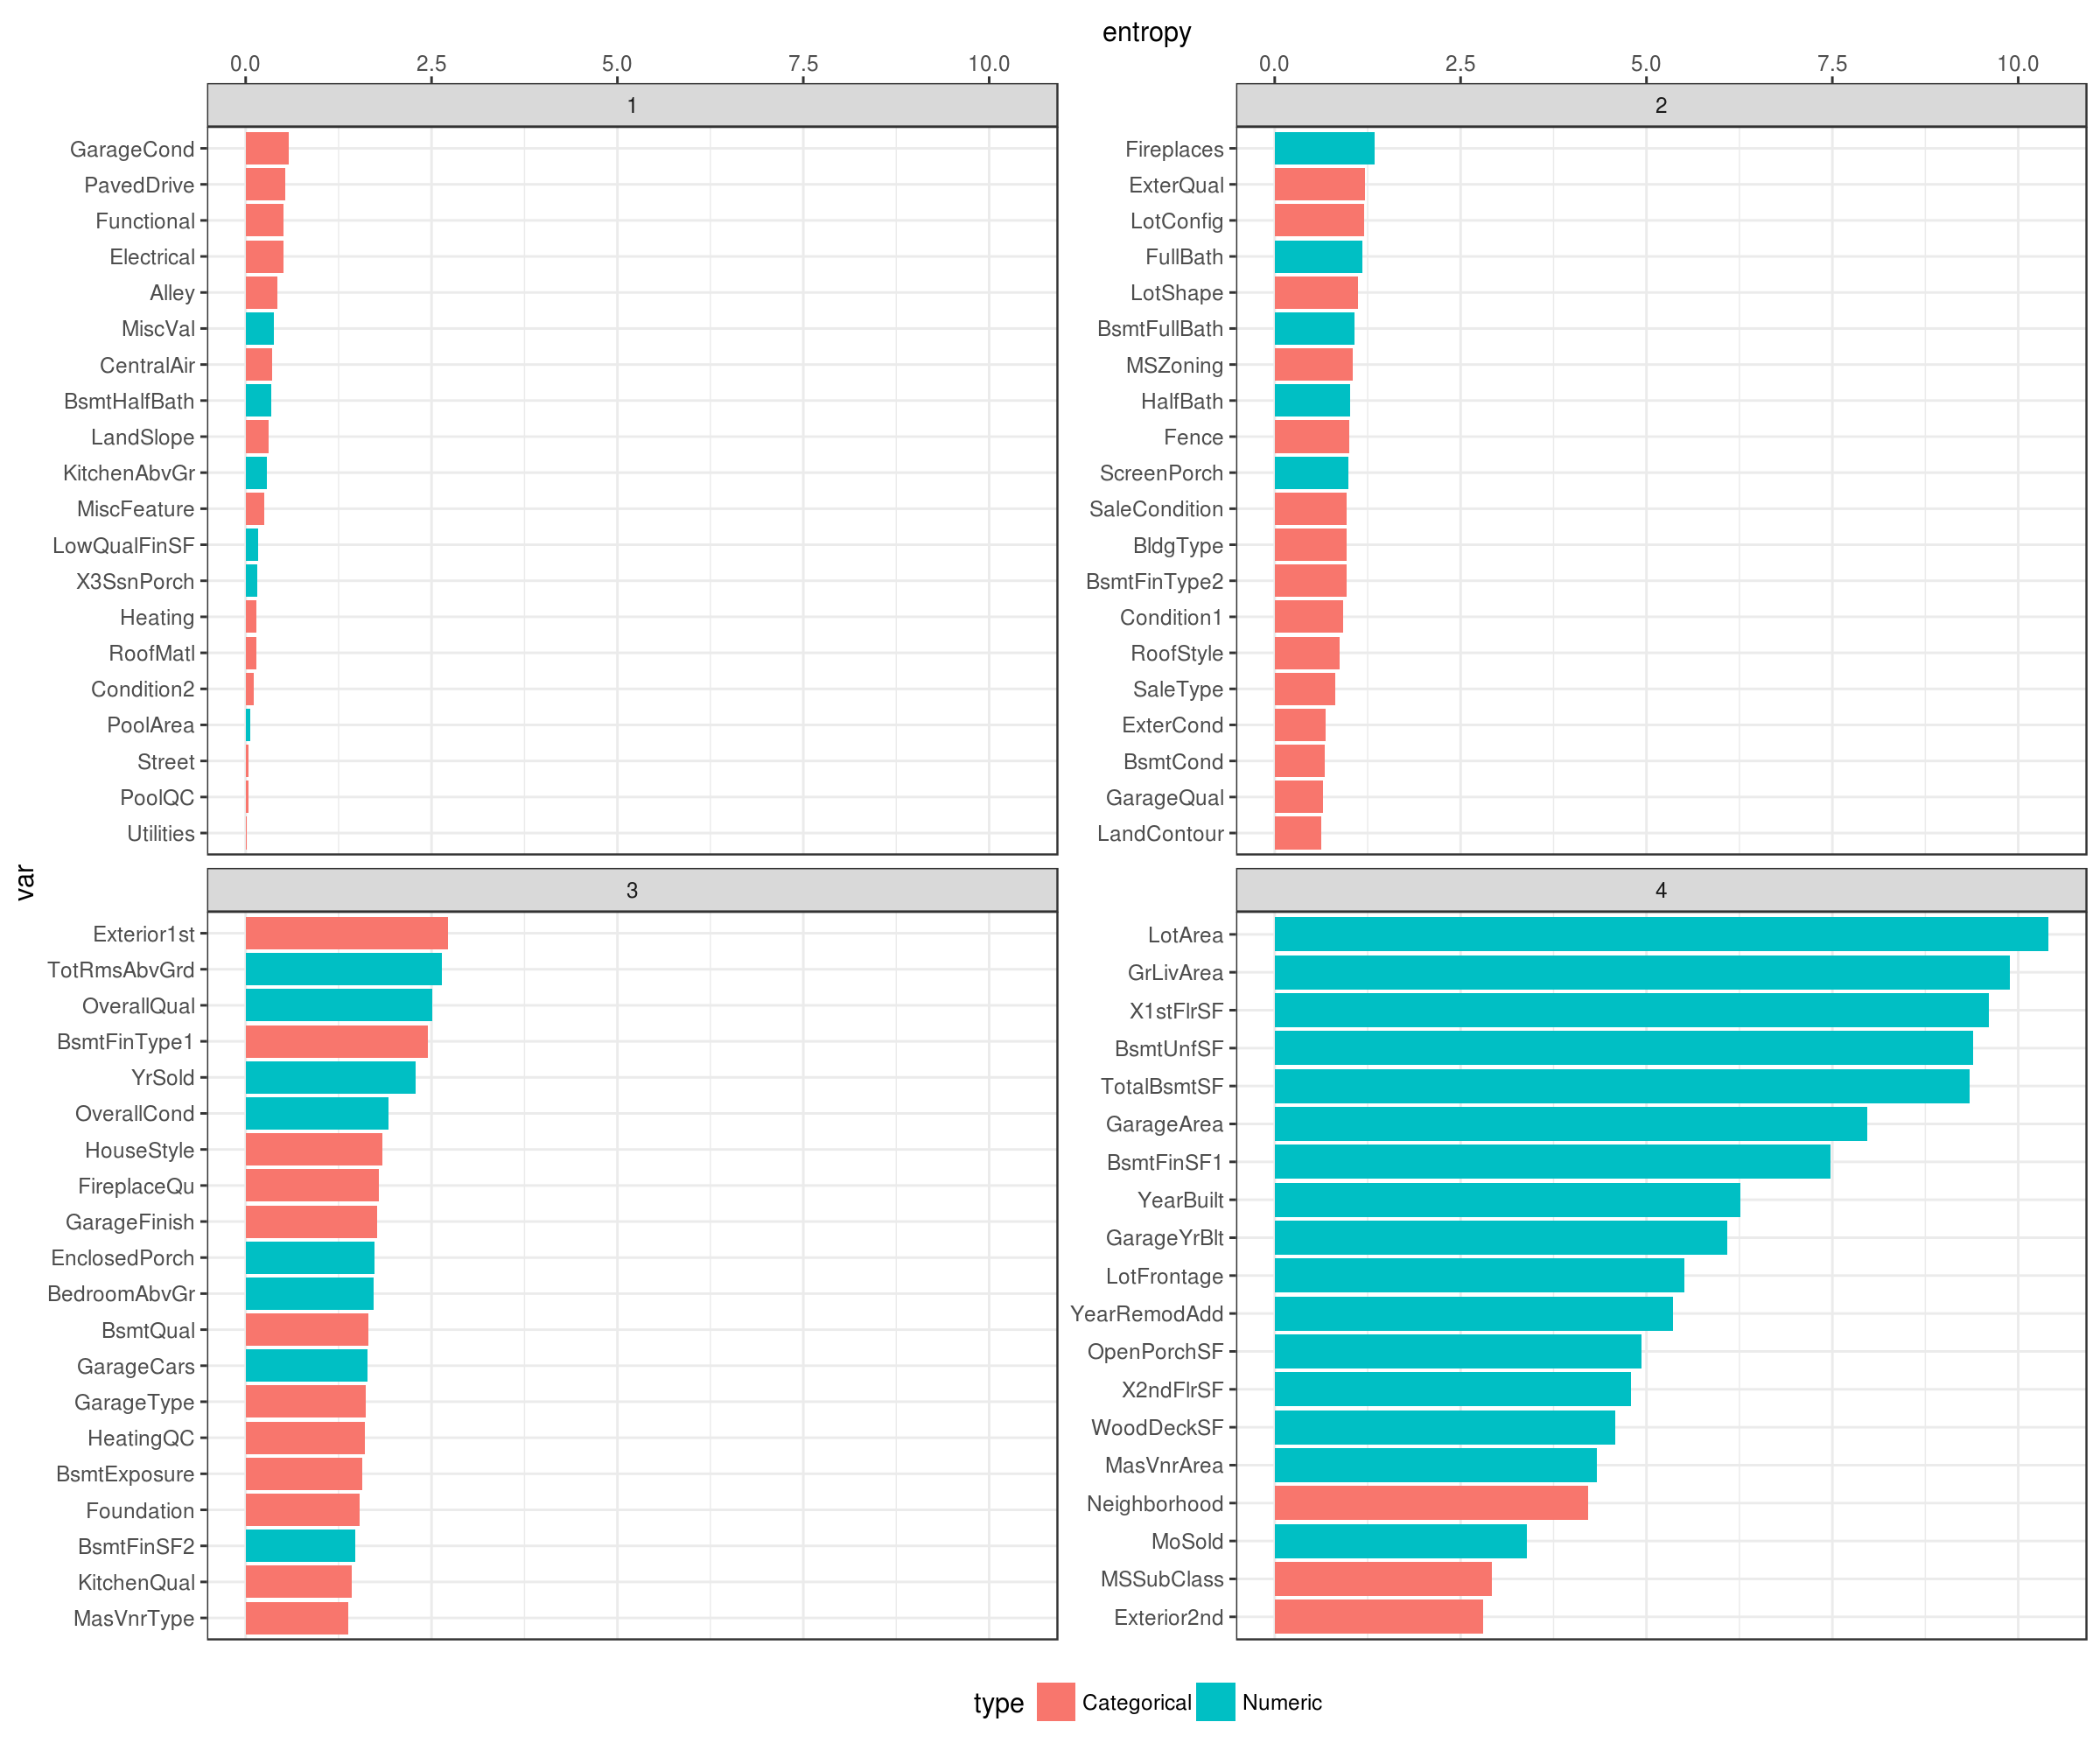

In [30]:
predictorsByEntropy <- 
    bind_rows(
        attr_sel$entropy$arrange_vars(
            numerData %>% select(-SalePrice, -Id)
        ) %>% mutate(type = "Numeric"),

        attr_sel$entropy$arrange_vars(
            categData %>% select(-SalePrice, -Id)
        ) %>% mutate(type = "Categorical")
    ) %>% 
    arrange(entropy)


show_table(
    list(predictorsByEntropy %>% tail(5), "Large entropy"),
    list(predictorsByEntropy %>% head(5), "Small entropy")
)


`@@@`(12, 10, 200)
predictorsByEntropy %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(4*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=entropy, fill=type)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 2, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# Separation between groups
##### Aplies only to categorical predictors. Variation on ANOVA theme.
This is custom measure of how levels of categorical variables are separated between each other relative to sale price. The bigger is the separation the more should be variable meaningful for the price prediction. If there is no separation between levels of a given variable then this variable is useless.

var,score,type
BsmtFinType1,0.1377131,Categorical
GarageFinish,0.3181379,Categorical
BsmtQual,0.4913273,Categorical
KitchenQual,0.5455861,Categorical
ExterQual,0.6638143,Categorical
var,score,type
Utilities,0.0001594599,Categorical
LandSlope,0.0006420930,Categorical
RoofMatl,0.0009775133,Categorical
Condition2,0.0010841188,Categorical


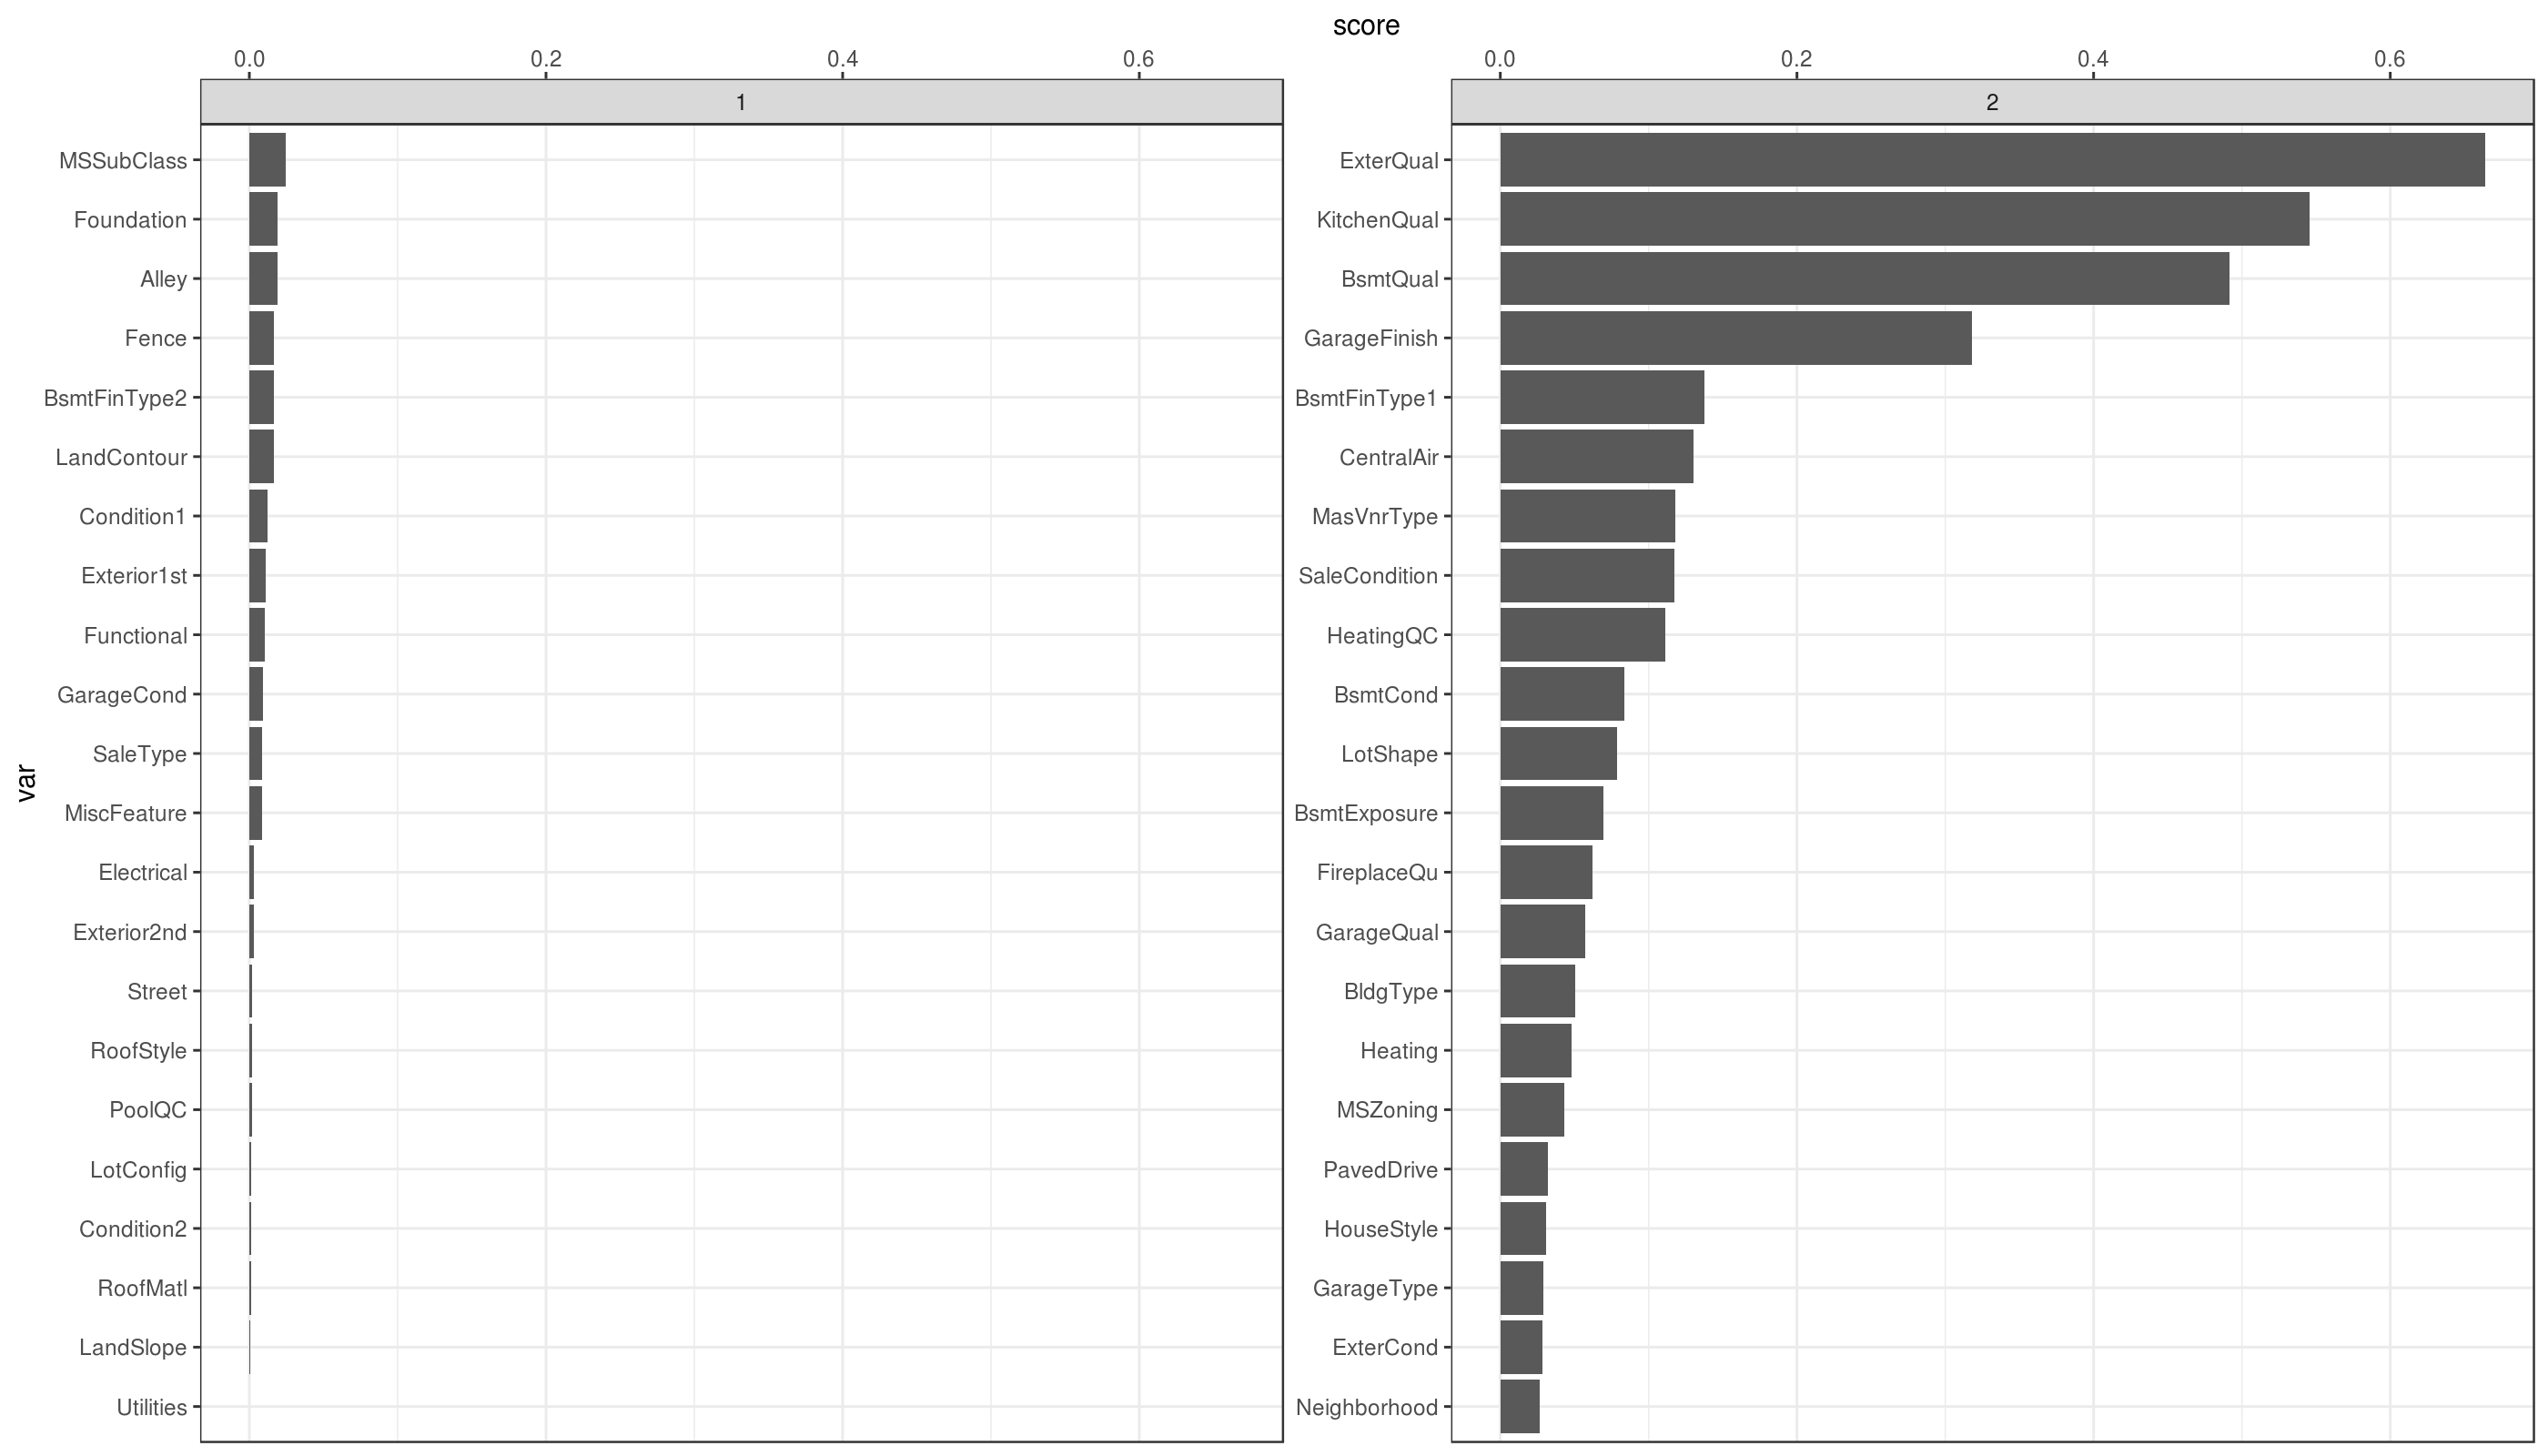

In [31]:
predictorsBySeparation <- 
    attr_sel$groups_separation$arrange_vars(
        df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id),
        target_var = price_log
    ) %>% 
    mutate(type = "Categorical")

show_table(
    list(predictorsBySeparation %>% tail(5), "Large separation"),
    list(predictorsBySeparation %>% head(5), "Small separation")
)


`@@@`(14, 8, 200)
predictorsBySeparation %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(2*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=score)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 1, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

### Visualising separation with two opposite test cases

In [8]:
# Helper function that orderes factor levels by SalePrice's mean value at that level.
# Otherwise ggplot will by default order levels lexicographically.
attr_sel$order_factor_by_target(
    df = categData %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
)$ExterQual %>% levels %>% show_list

Fa TA Gd Ex

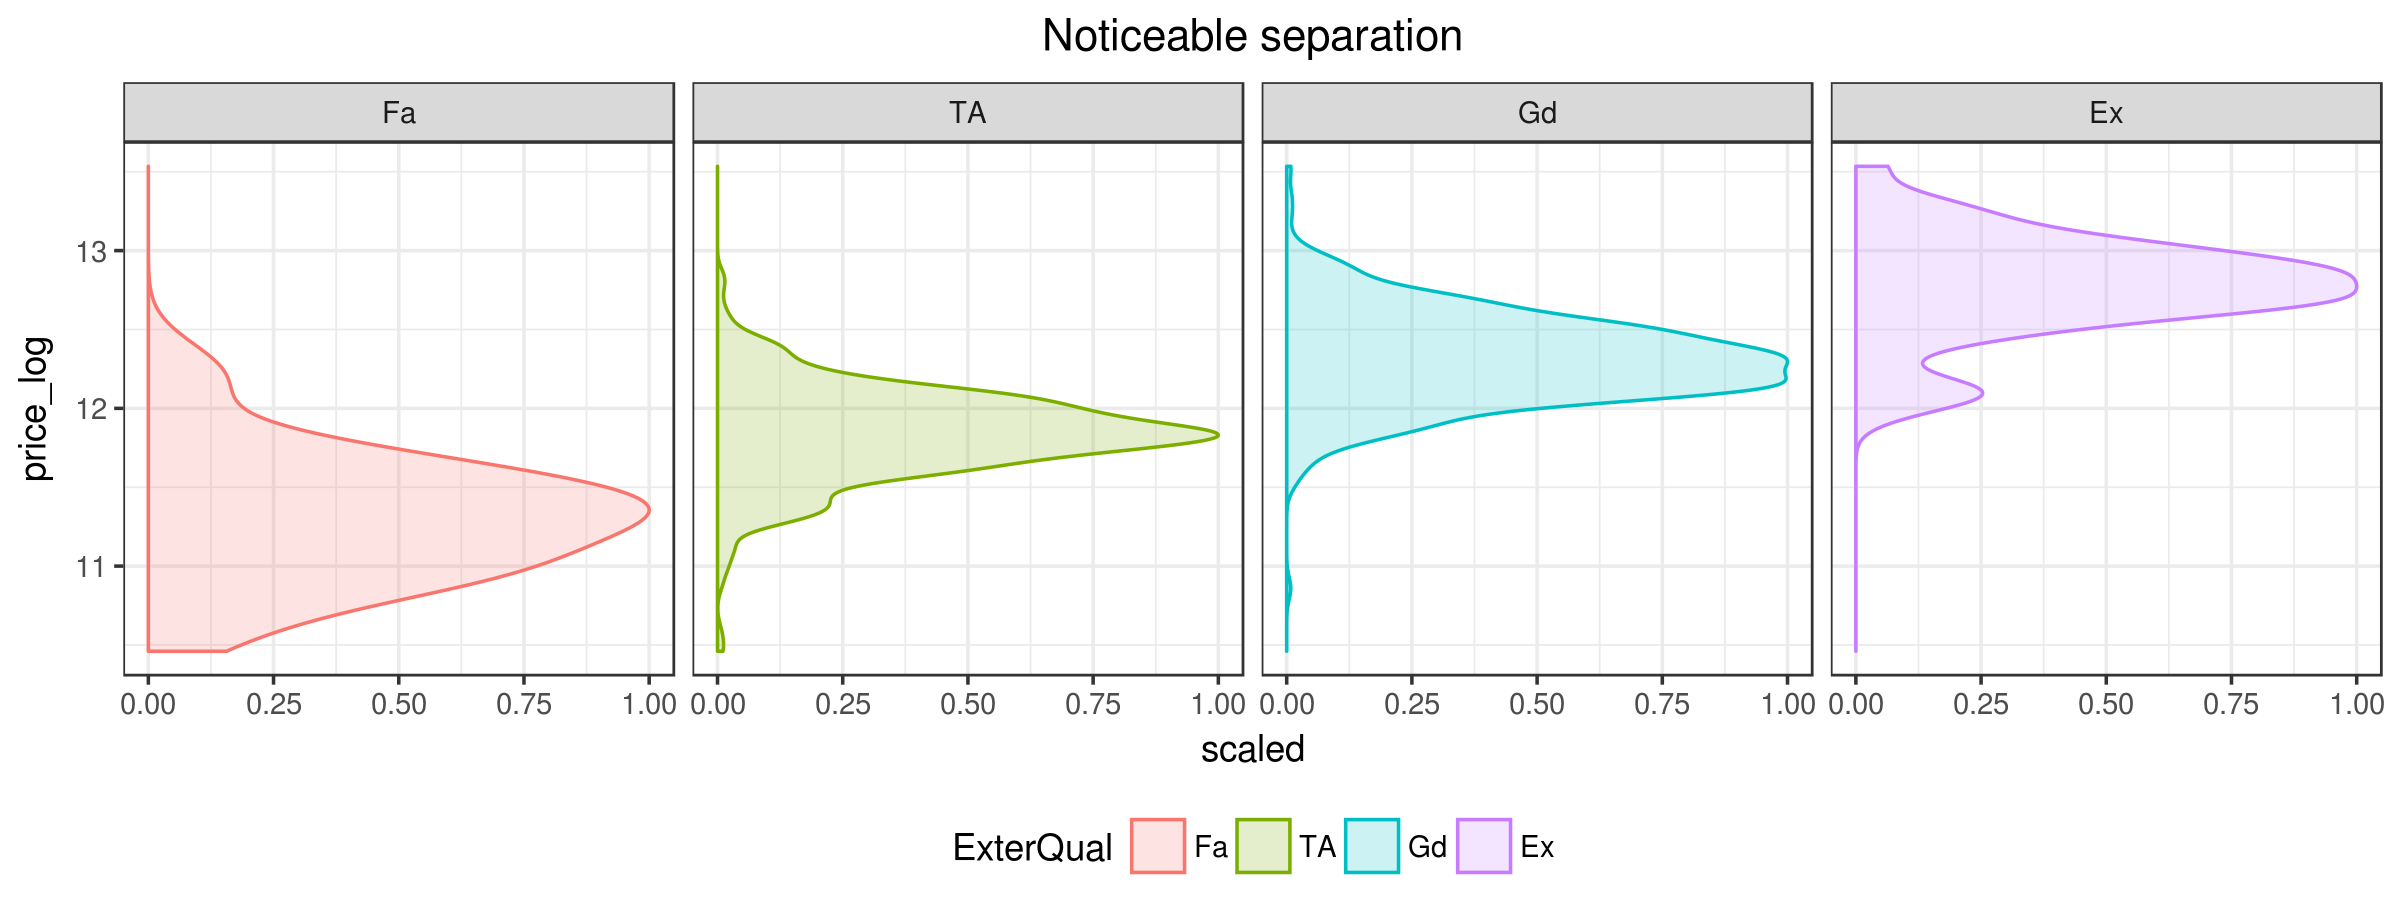

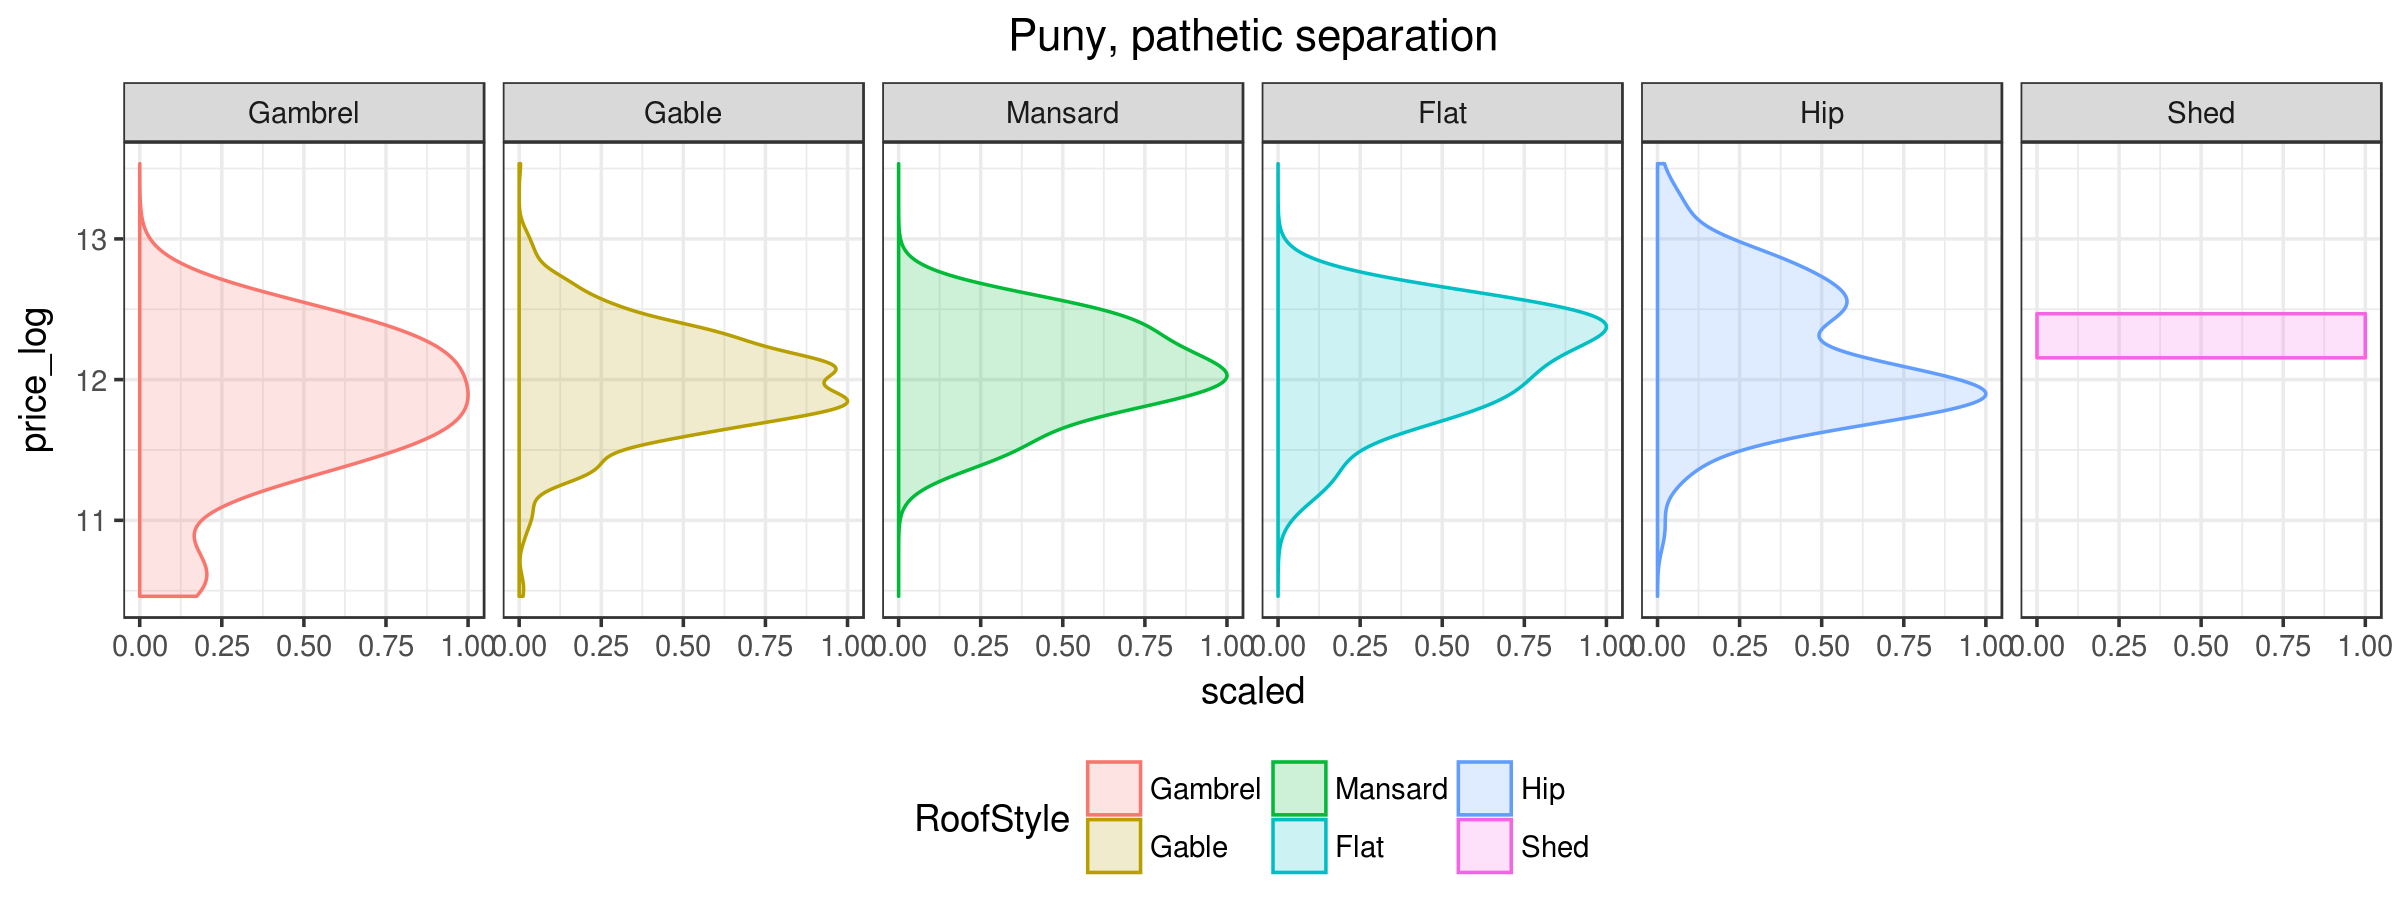

In [9]:
df <- 
    categData %>% 
    filter(!is.na(SalePrice)) %>% 
    select(ExterQual, RoofStyle, SalePrice) %>%
    mutate(price_log = log(SalePrice)) %>%
    select(-SalePrice)


`@@@`(10, 3.8, 240)
attr_sel$order_factor_by_target(
    df = df, 
    factor_var = ExterQual, 
    target_var = price_log
) %>%
ggplot(aes(price_log, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Noticeable separation")


`@@@`(10, 3.8, 240)
attr_sel$order_factor_by_target(
    df = df, 
    factor_var = RoofStyle, 
    target_var = price_log
) %>%
ggplot(aes(price_log, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Puny, pathetic separation")

### Ordering factors by $R^2$ of $log(SalePrice) \sim factor$

var,r2,type
ExterQual,0.4611220,Categorical
GarageCars,0.4632501,Numeric
GrLivArea,0.4912982,Numeric
Neighborhood,0.5708078,Categorical
OverallQual,0.6677904,Numeric
var,r2,type
BsmtFinSF2,2.335219e-05,Numeric
BsmtHalfBath,2.651317e-05,Numeric
Utilities,1.595693e-04,Categorical
MiscVal,4.008332e-04,Numeric


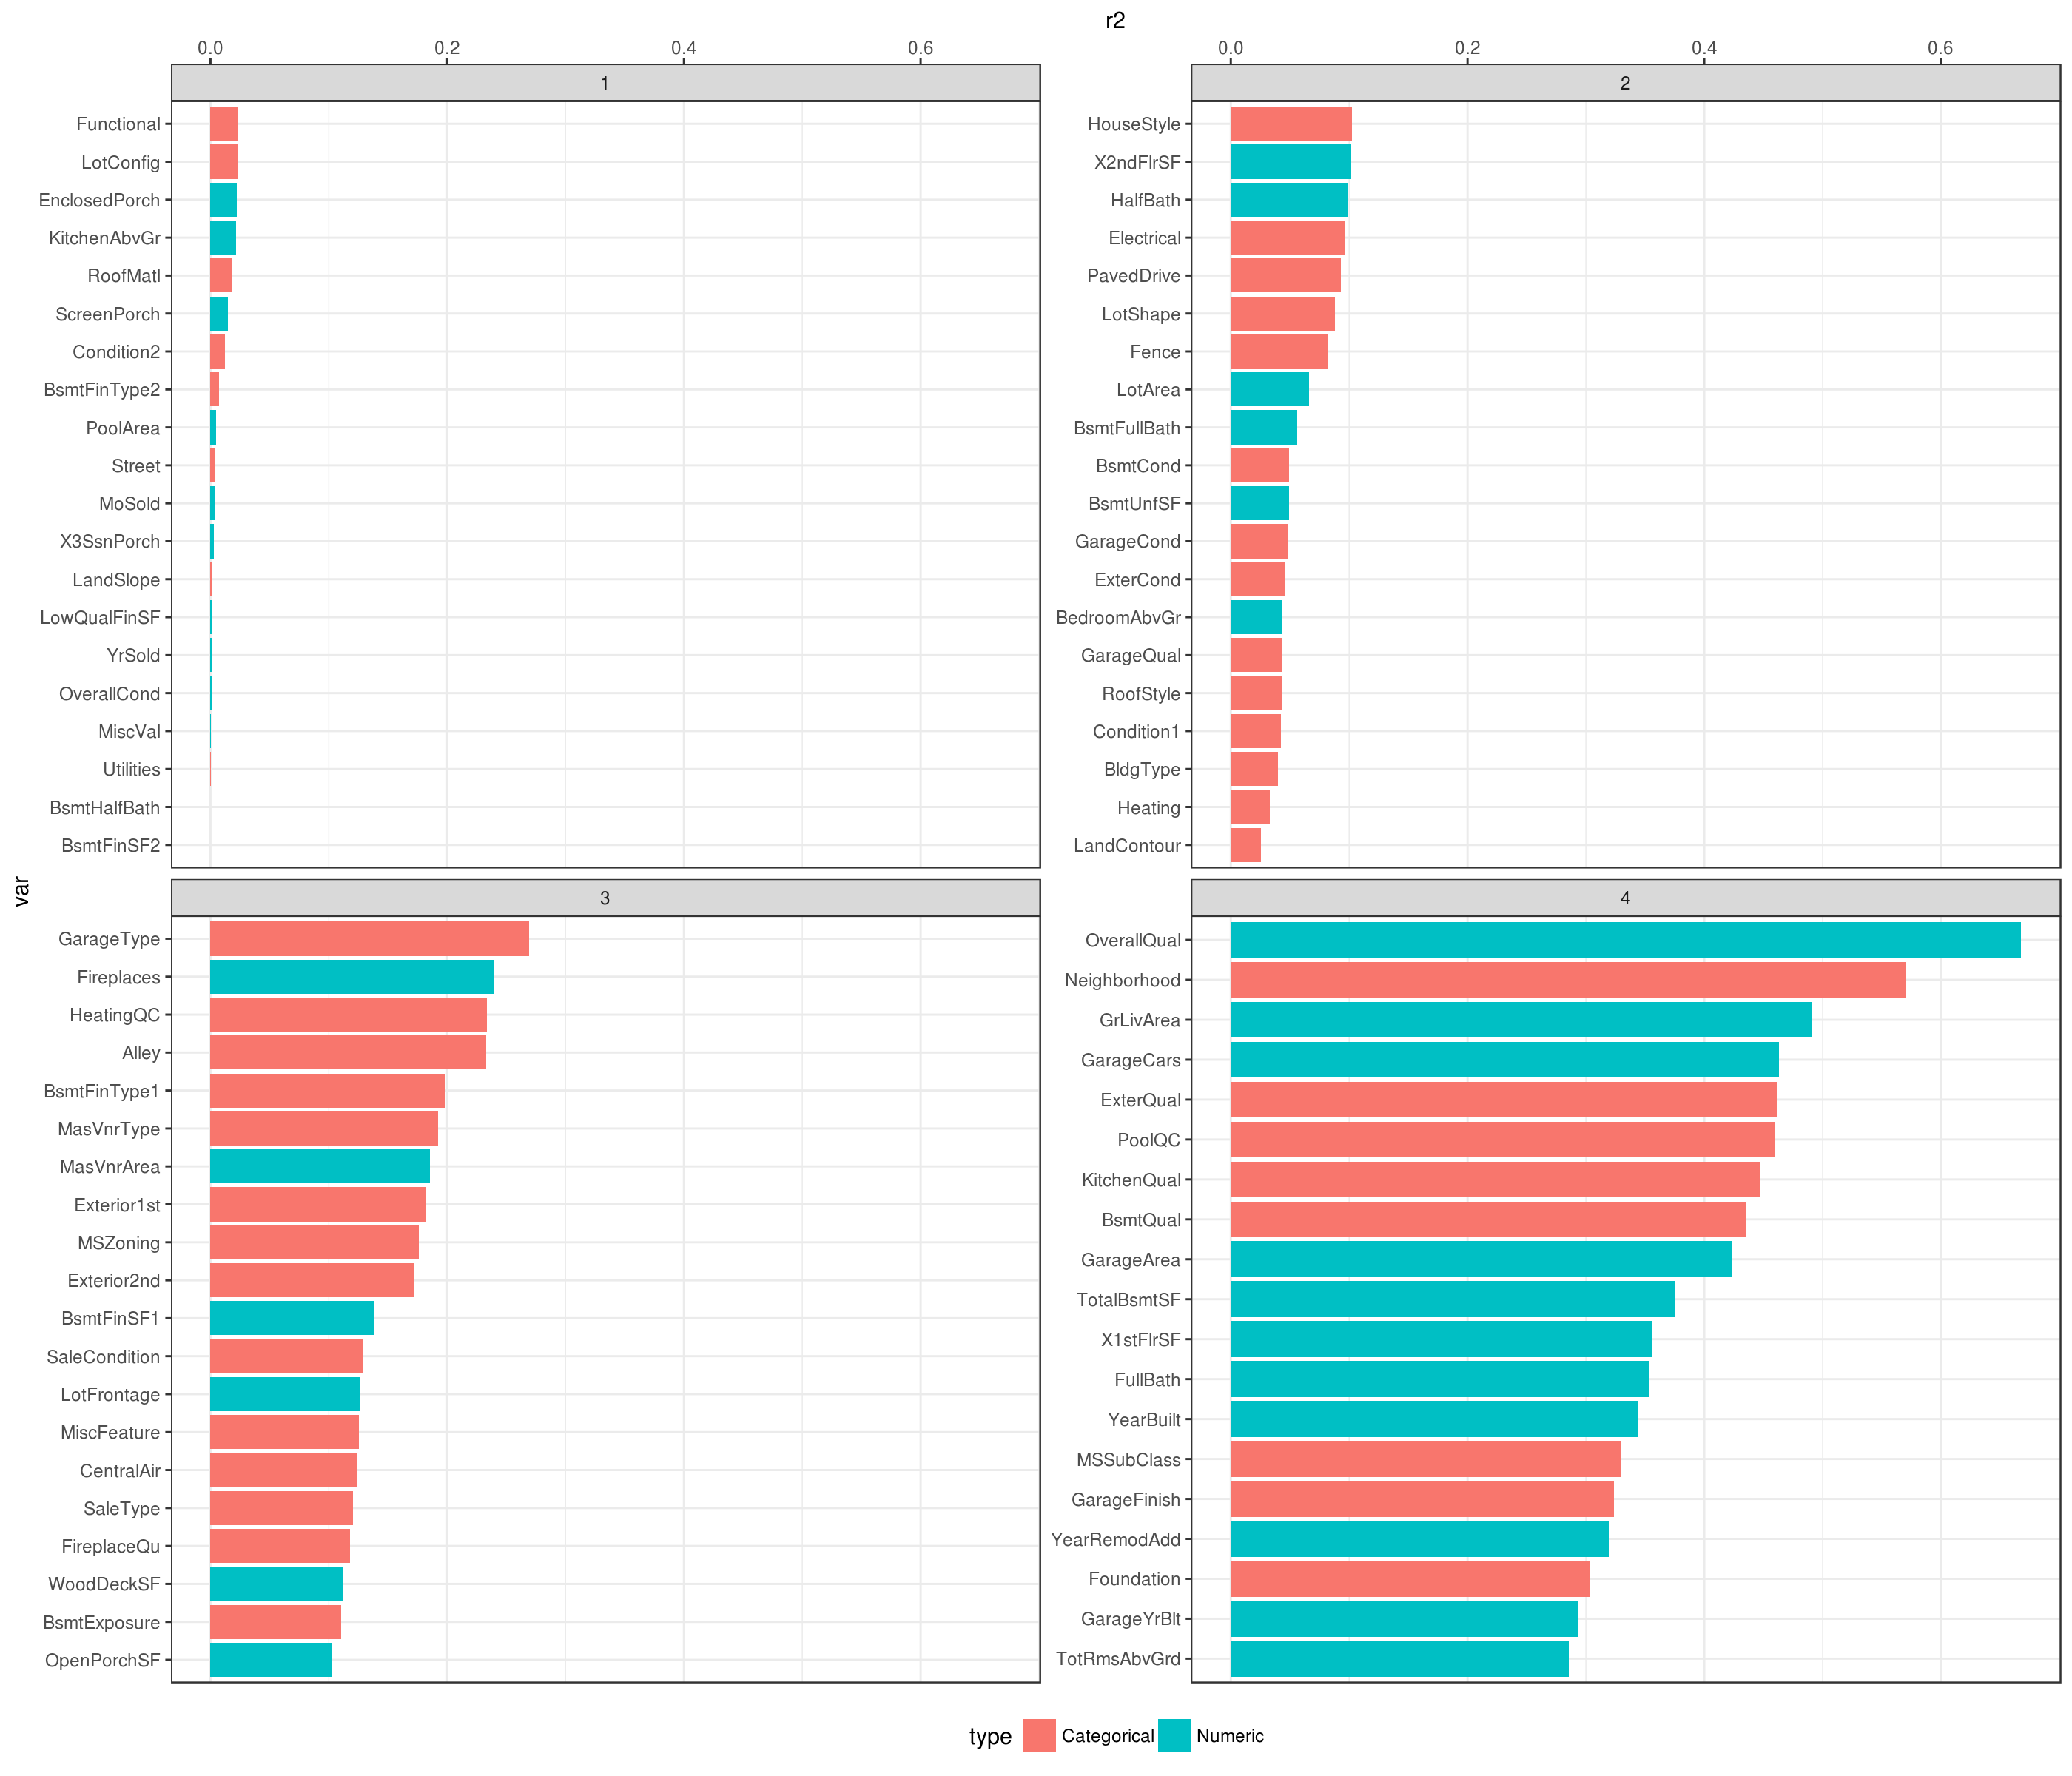

In [32]:
categ_vars_by_r2 <- 
    attr_sel$Rsquared$arrange_vars(
        df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
        target_var = price_log
    )

numeric_vars_by_r2 <- 
    attr_sel$Rsquared$arrange_vars(
        df = numerData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
        target_var = price_log
    )

predictorsByR2 <- 
    bind_rows(
        categ_vars_by_r2 %>% mutate(type = "Categorical"),
        numeric_vars_by_r2 %>% mutate(type = "Numeric")
    ) %>% 
    arrange(r2)


show_table(
    list(predictorsByR2 %>% tail(5), "Large R2"),
    list(predictorsByR2 %>% head(5), "Small R2")
)


`@@@`(14, 12, 200)
predictorsByR2 %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(4*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=r2, fill=type)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 2, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# By Fisher statistics

#### Basically one-way ANOVA

var,F,type
CentralAir,205.6670,Categorical
GarageFinish,298.7698,Categorical
BsmtQual,300.3923,Categorical
KitchenQual,393.3202,Categorical
ExterQual,415.3034,Categorical
var,F,type
Utilities,0.2326891,Categorical
LandSlope,1.0830389,Categorical
Condition2,2.5277400,Categorical
MiscFeature,3.6212358,Categorical


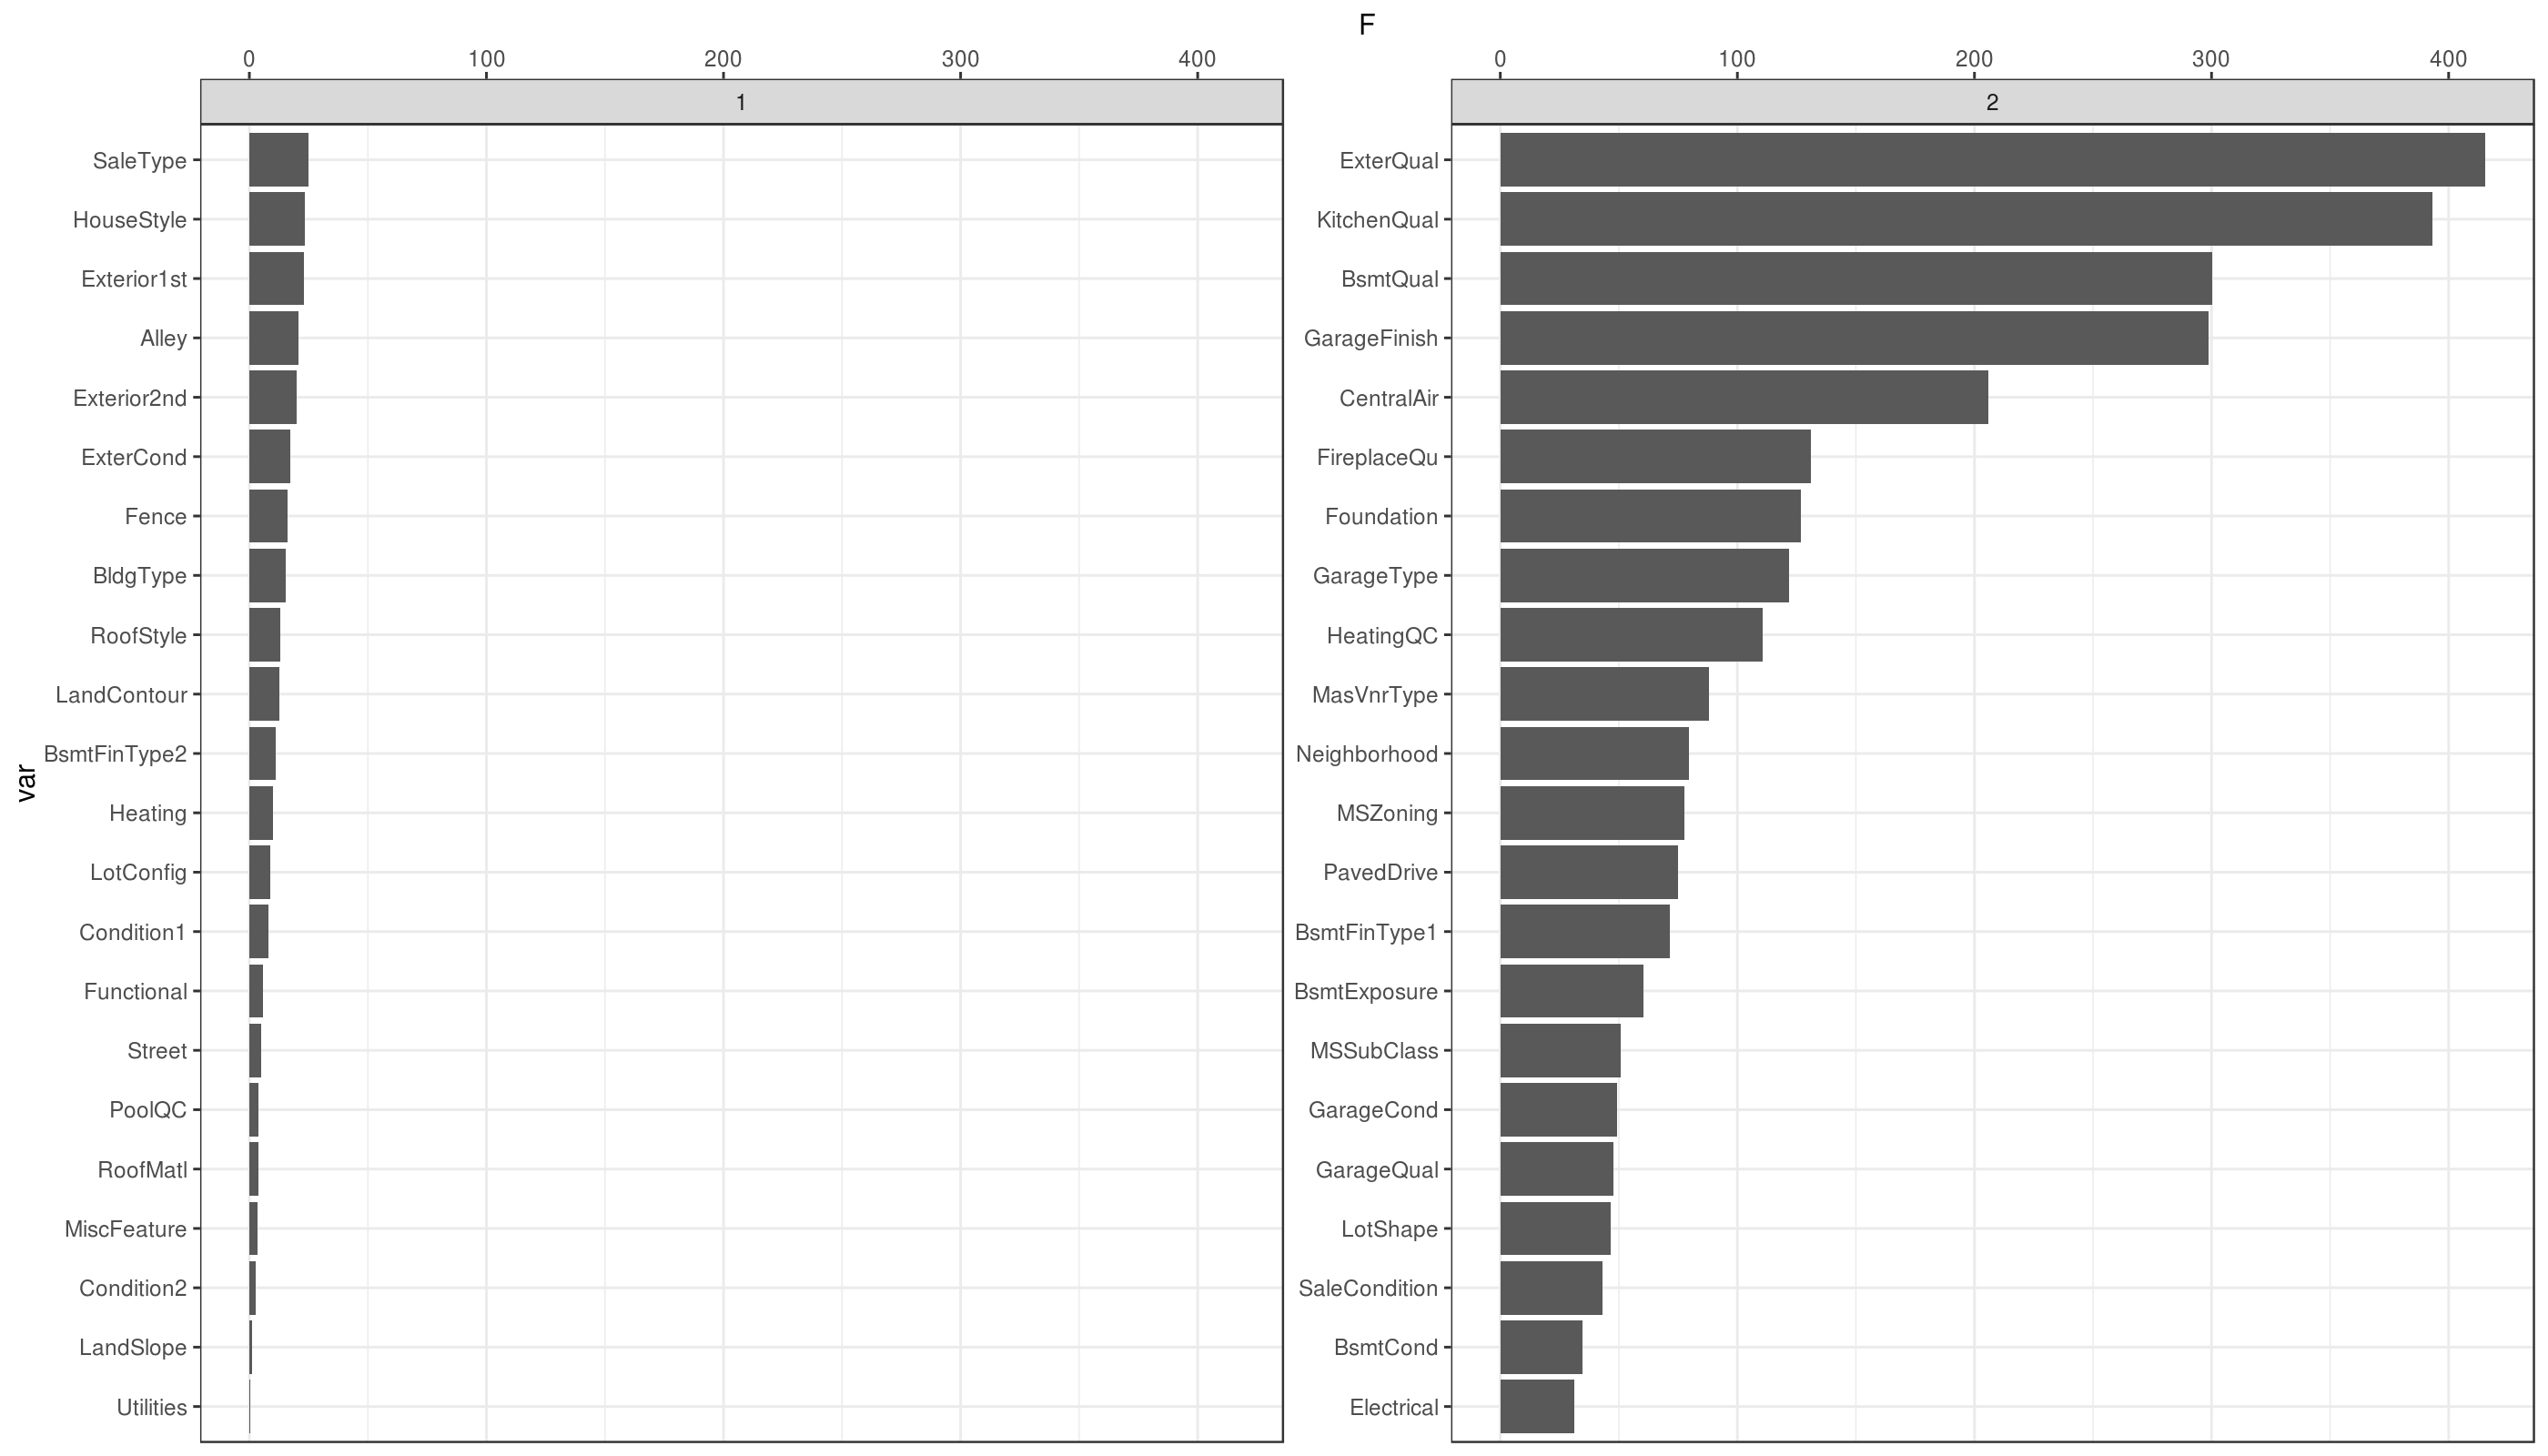

In [33]:
predictorsByFisher <- 
    attr_sel$anova$arrange_vars(
        df = categData %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice, -Id), 
        target_var = price_log
    ) %>% 
    mutate(type = "Categorical")

show_table(
    list(predictorsByFisher %>% tail(5), "Large F"),
    list(predictorsByFisher %>% head(5), "Small F")
)

`@@@`(14, 8, 200)
predictorsByFisher %>%
mutate(
    var = factor(var, levels=var),
    basket = floor(2*(row_number() - 1)/nrow(.)) + 1
) %>%
ggplot(aes(x=var, y=F)) +
geom_bar(stat="identity") +
facet_wrap(~basket, nrow = 1, ncol = 2, scales="free_y") +
coord_flip() +
scale_y_continuous(position = "top") +
theme_bw() +
theme(legend.position = "bottom")

# Everything together

In [97]:
together <-
    bind_rows(
        predictorsByEntropy %>% mutate(metric = 'entropy') %>% rename(value = entropy),
        predictorsBySeparation %>% mutate(metric = 'separation') %>% rename(value = score),
        predictorsByR2 %>% mutate(metric = 'r2') %>% rename(value = r2),
        predictorsByFisher %>% mutate(metric = 'F') %>% rename(value = F)
    ) %>% 
    group_by(type, metric) %>%
    mutate(value_normed = value / max(value)) %>%
    ungroup %>%
    arrange(type, metric, value_normed)


together %>% head(3) %>% show_table

var,value,type,metric,value_normed
Utilities,0.01262749,Categorical,entropy,0.002997908
PoolQC,0.03820308,Categorical,entropy,0.009069843
Street,0.03850369,Categorical,entropy,0.009141210


var,metric,value_normed
Utilities,entropy,0.002997908
LandSlope,entropy,0.072125398
Street,entropy,0.009141210


(44 elems) Utilities LandSlope Street BsmtFinType2 Condition2 RoofMatl LotConfig Functional LandContour Heating BldgType Condition1 RoofStyle GarageQual ExterCond GarageCond BsmtCond Fence LotShape PavedDrive Electrical HouseStyle BsmtExposure FireplaceQu SaleType CentralAir MiscFeature SaleCondition Exterior2nd MSZoning Exterior1st MasVnrType BsmtFinType1 Alley HeatingQC GarageType Foundation GarageFinish MSSubClass BsmtQual KitchenQual PoolQC ExterQual Neighborhood

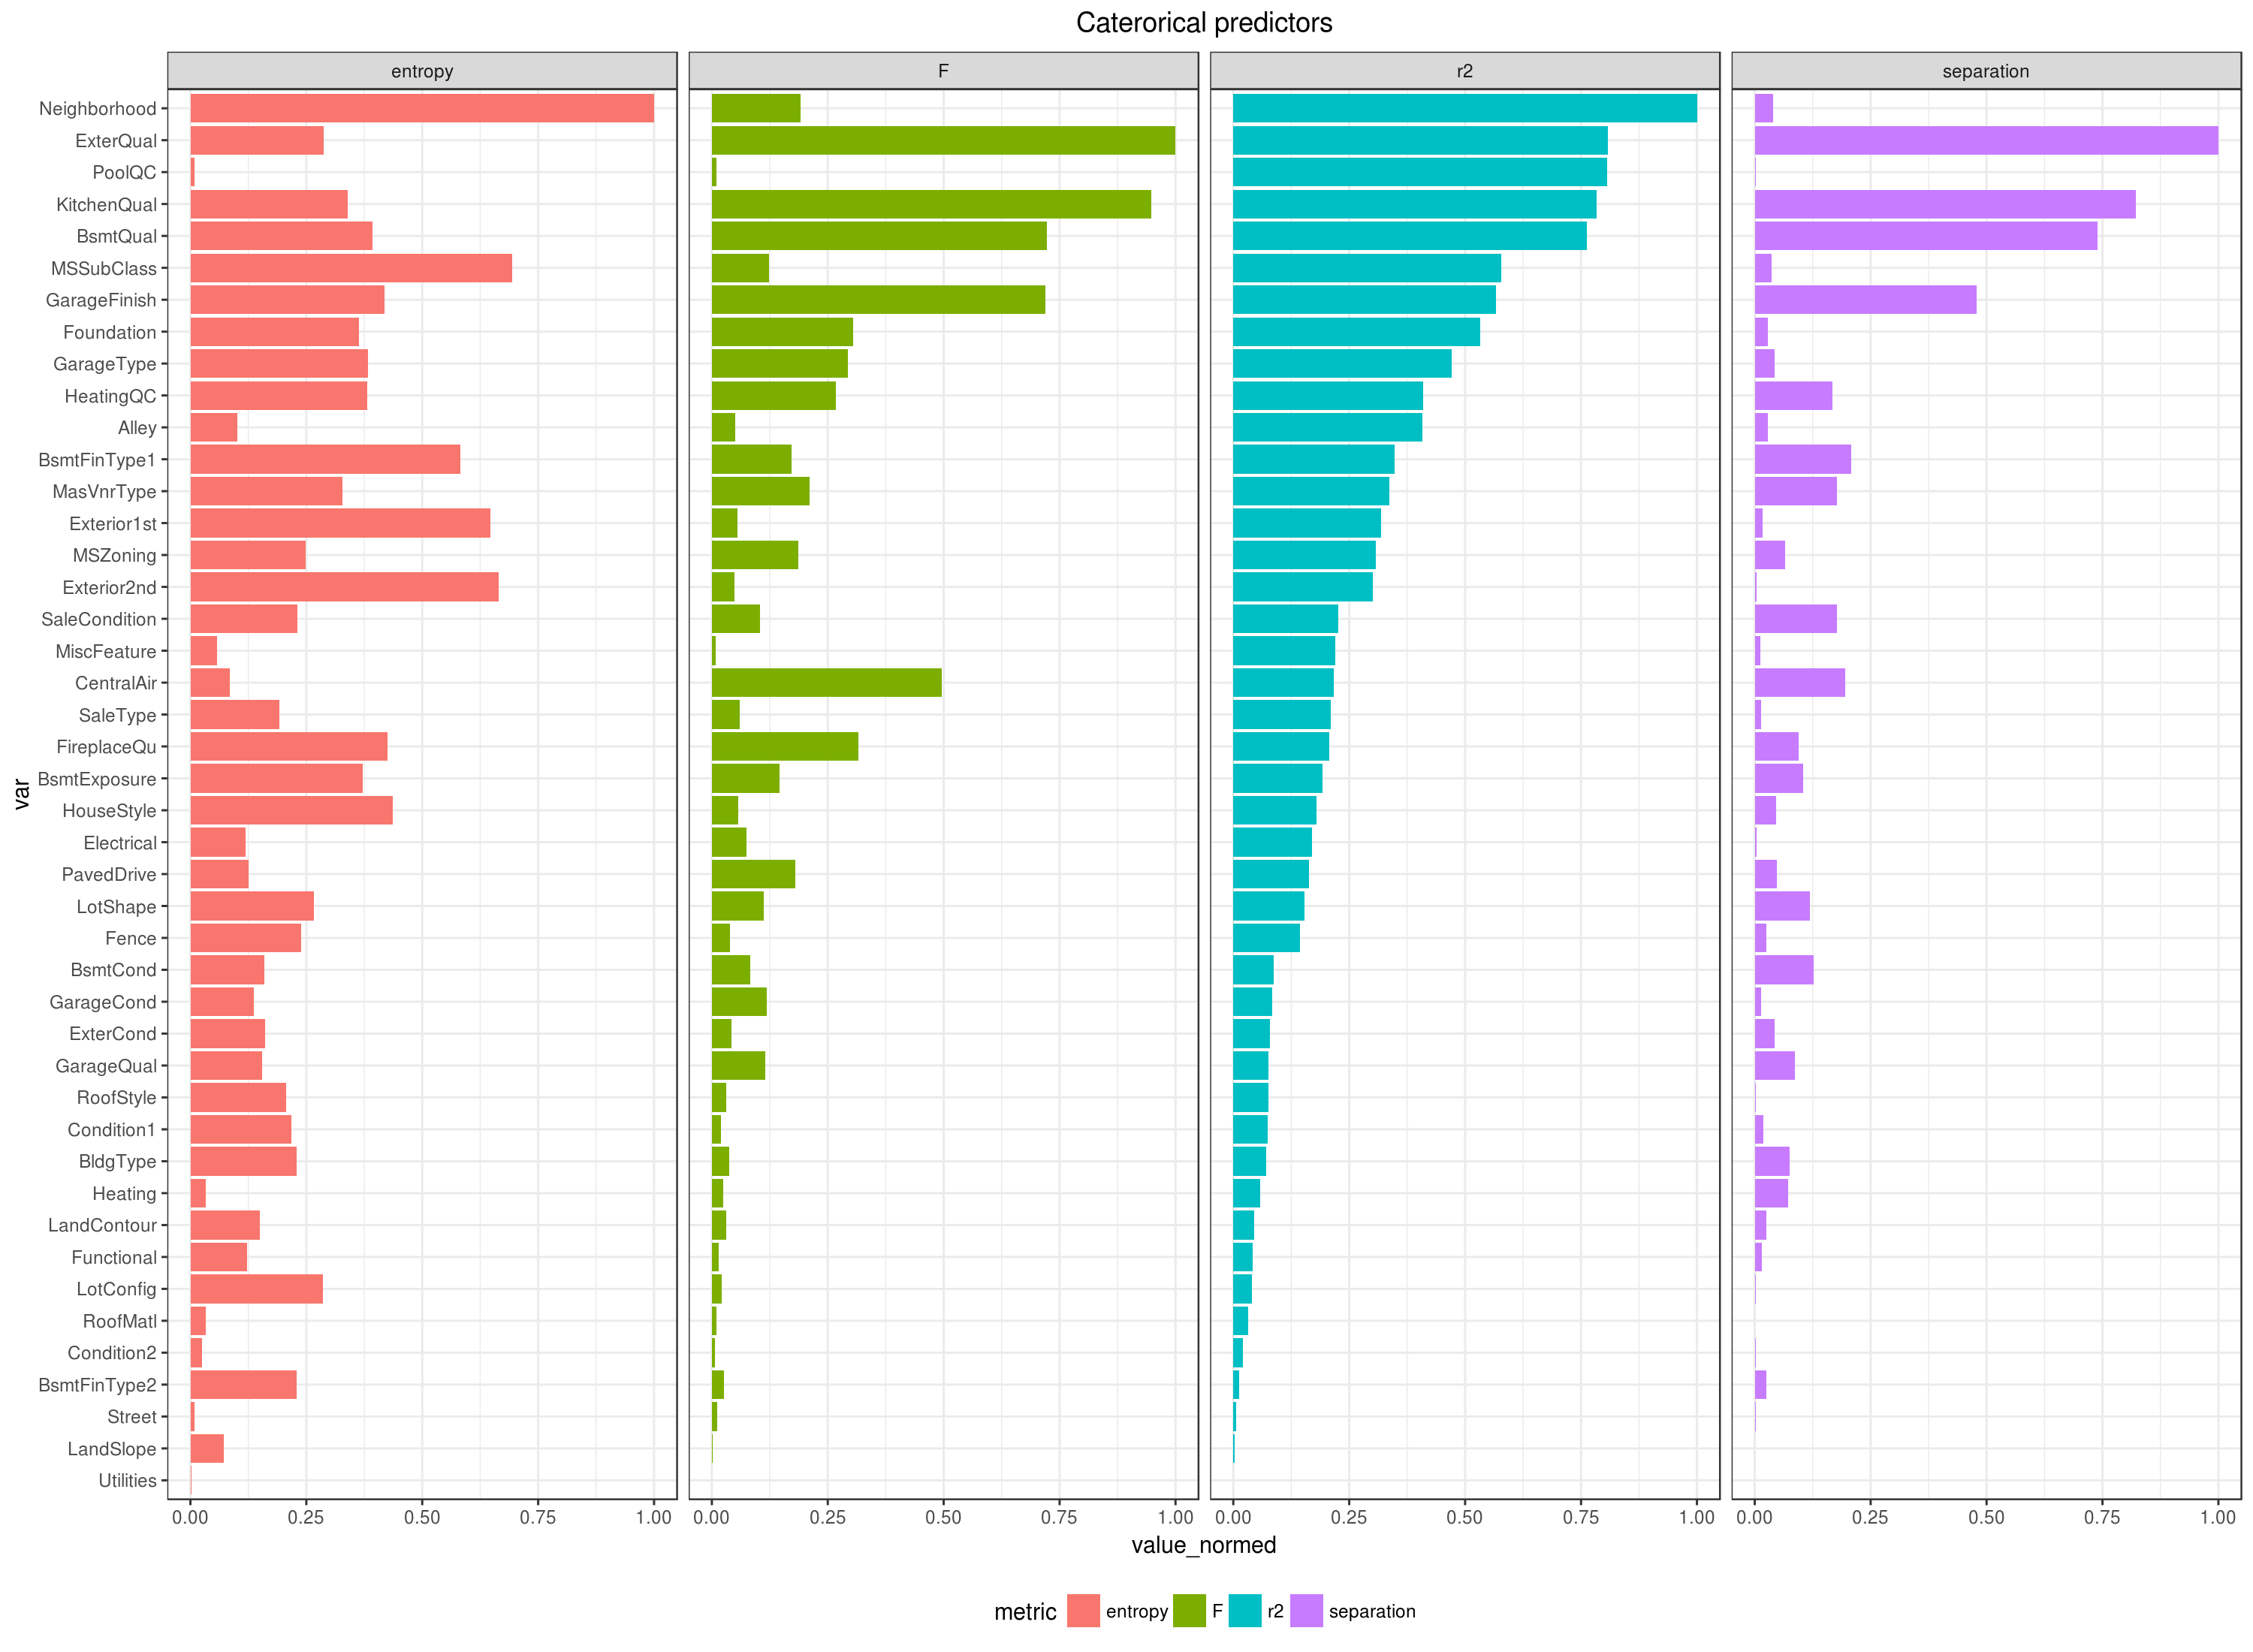

In [106]:
together_cat <-
    together %>% 
    filter(type == "Categorical") %>%
    select(-type, -value) %>%
    spread(metric, value_normed) %>%
    arrange(r2) %>%
    mutate(
        var = factor(var, levels = var)
    ) %>%
    gather(metric, value_normed, -var)


together_cat %>% head(3) %>% show_table
together_cat$var %>% levels %>% show_list


`@@@`(15, 11, 200)
together_cat %>%
ggplot(aes(x=var, y=value_normed, fill=metric)) +
geom_bar(stat="identity") +
coord_flip() +
facet_wrap(~metric, nrow = 1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Caterorical predictors")

var,metric,value_normed
BsmtFinSF2,entropy,0.14201632
BsmtHalfBath,entropy,0.03315266
MiscVal,entropy,0.03604631


(35 elems) BsmtFinSF2 BsmtHalfBath MiscVal OverallCond YrSold LowQualFinSF X3SsnPorch MoSold PoolArea ScreenPorch KitchenAbvGr EnclosedPorch BedroomAbvGr BsmtUnfSF BsmtFullBath LotArea HalfBath X2ndFlrSF OpenPorchSF WoodDeckSF LotFrontage BsmtFinSF1 MasVnrArea Fireplaces TotRmsAbvGrd GarageYrBlt YearRemodAdd YearBuilt FullBath X1stFlrSF TotalBsmtSF GarageArea GarageCars GrLivArea OverallQual

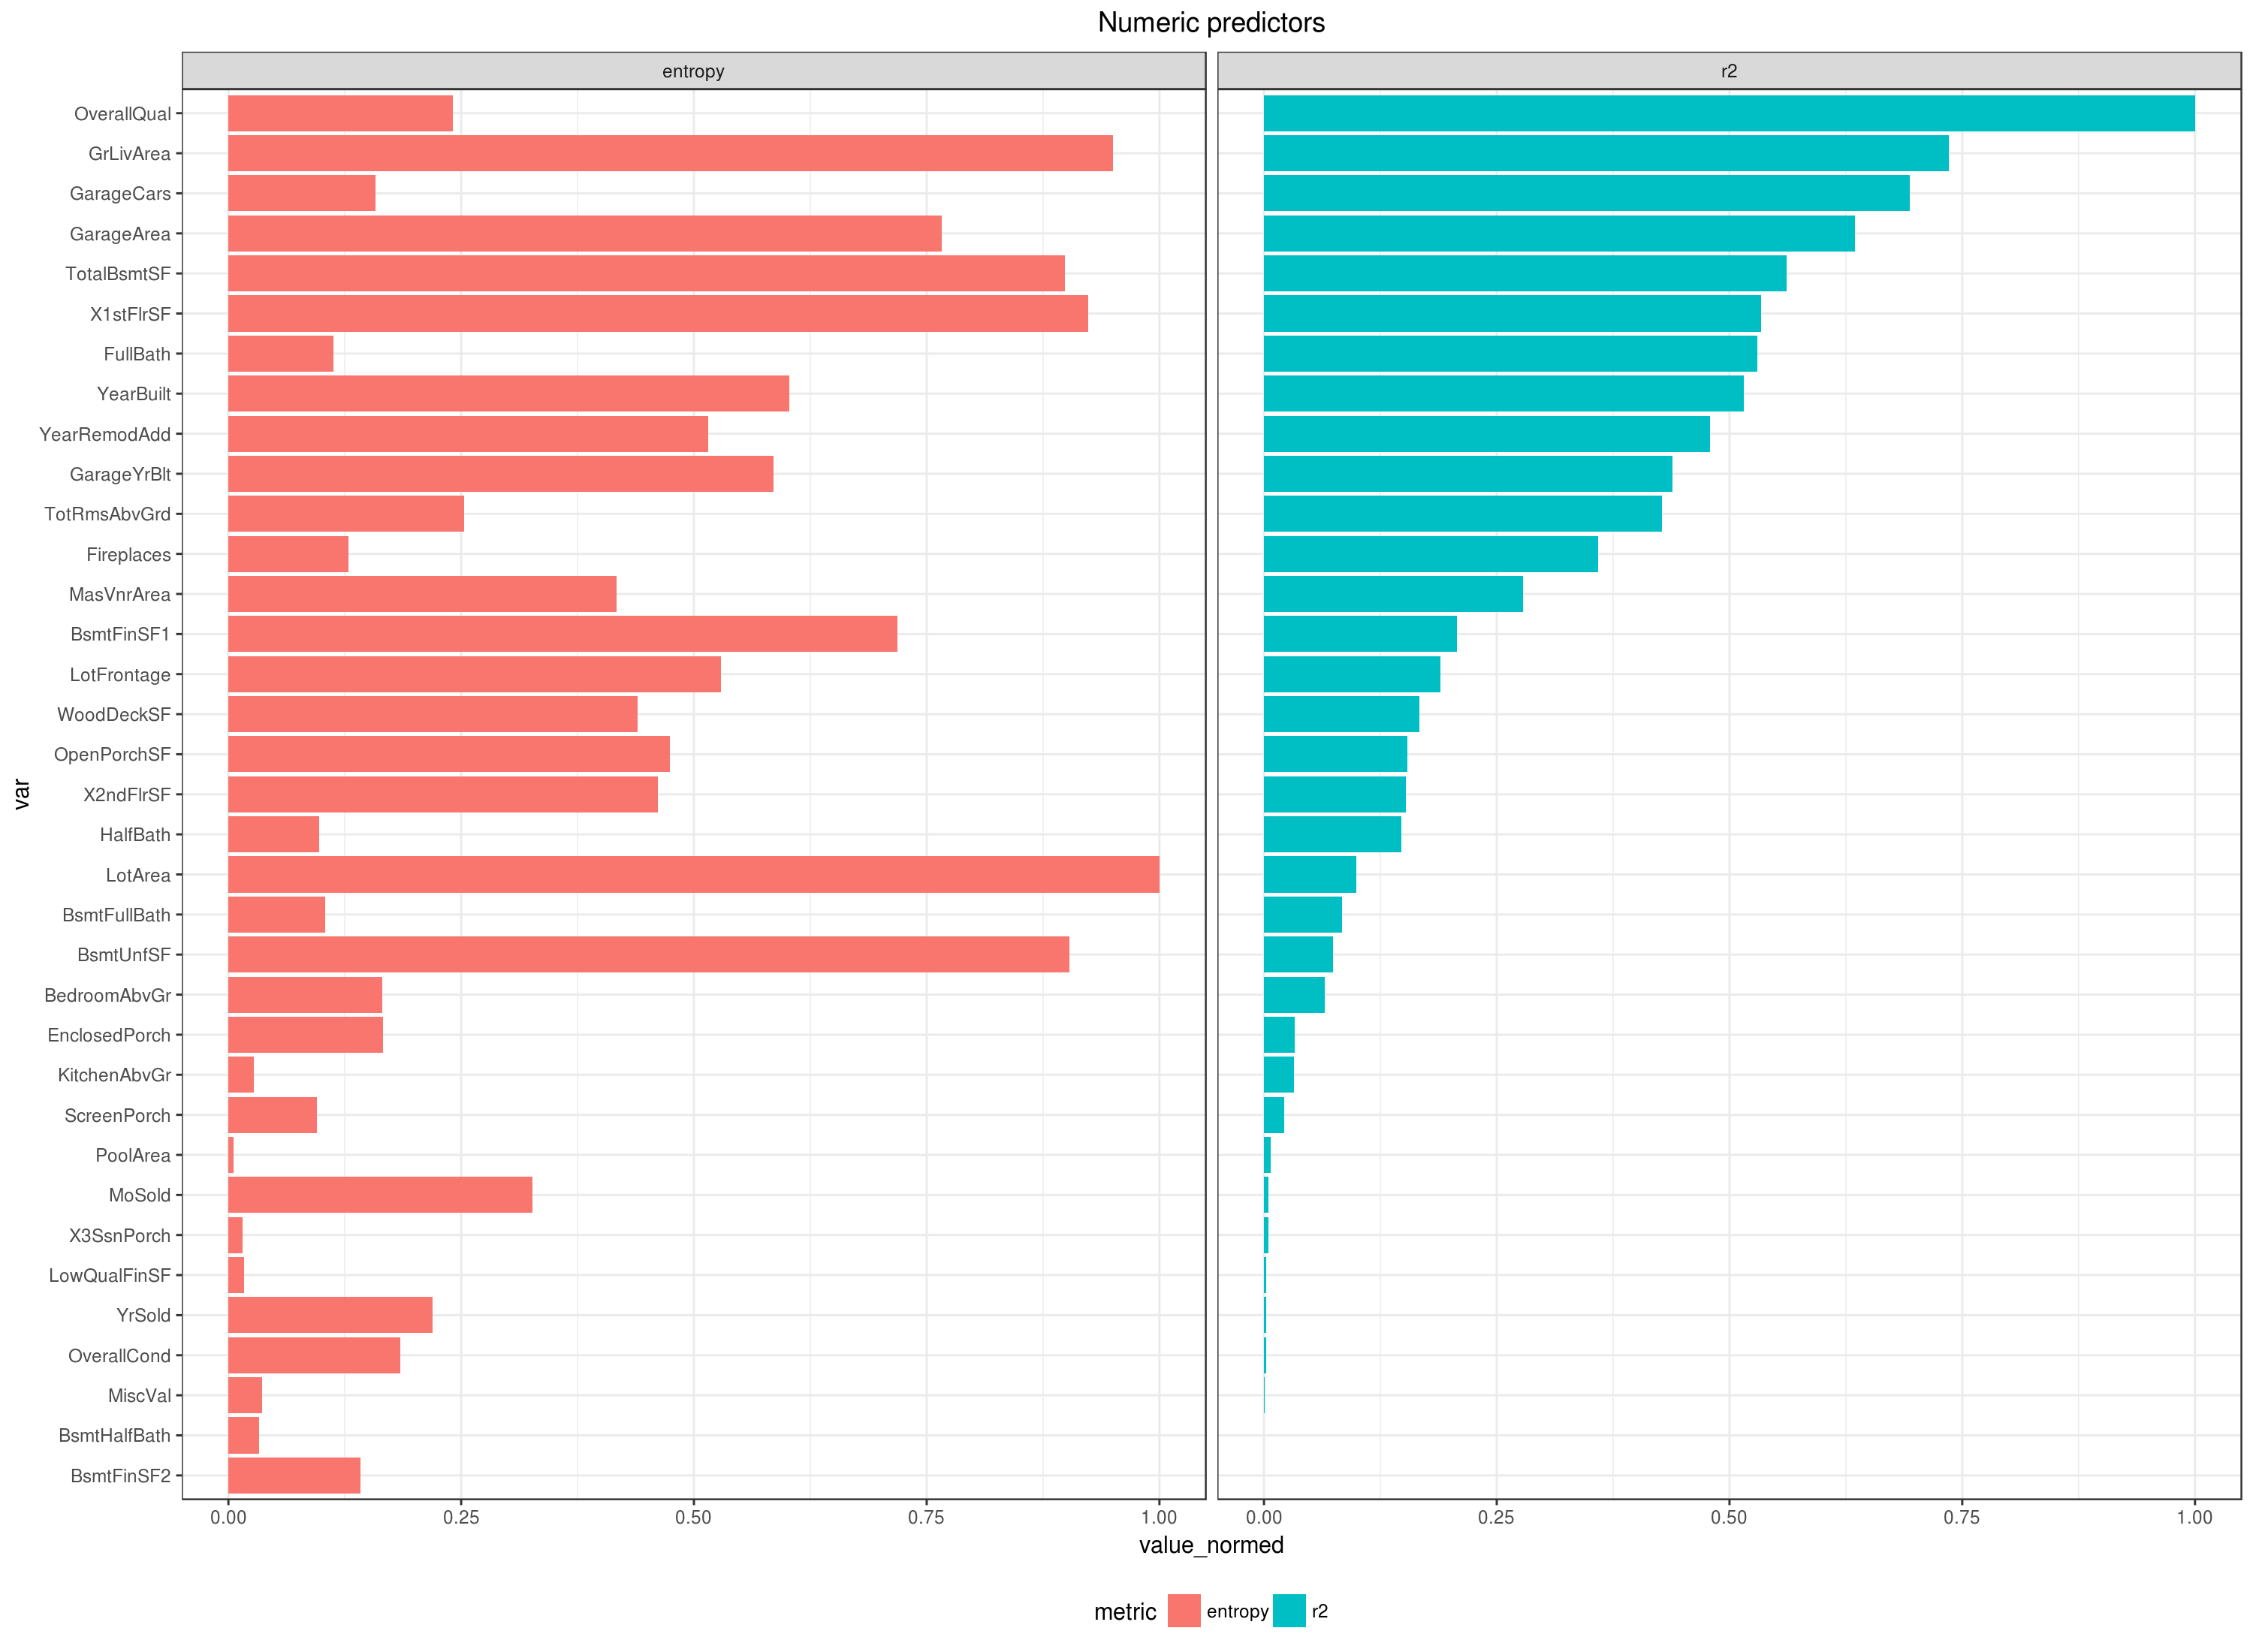

In [107]:
together_num <-
    together %>% 
    filter(type == "Numeric") %>%
    select(-type, -value) %>%
    spread(metric, value_normed) %>%
    arrange(r2) %>%
    mutate(
        var = factor(var, levels = var)
    ) %>%
    gather(metric, value_normed, -var)


together_num %>% head(3) %>% show_table
together_num$var %>% levels %>% show_list


`@@@`(15, 11, 200)
together_num %>%
ggplot(aes(x=var, y=value_normed, fill=metric)) +
geom_bar(stat="identity") +
coord_flip() +
facet_wrap(~metric, nrow = 1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Numeric predictors")

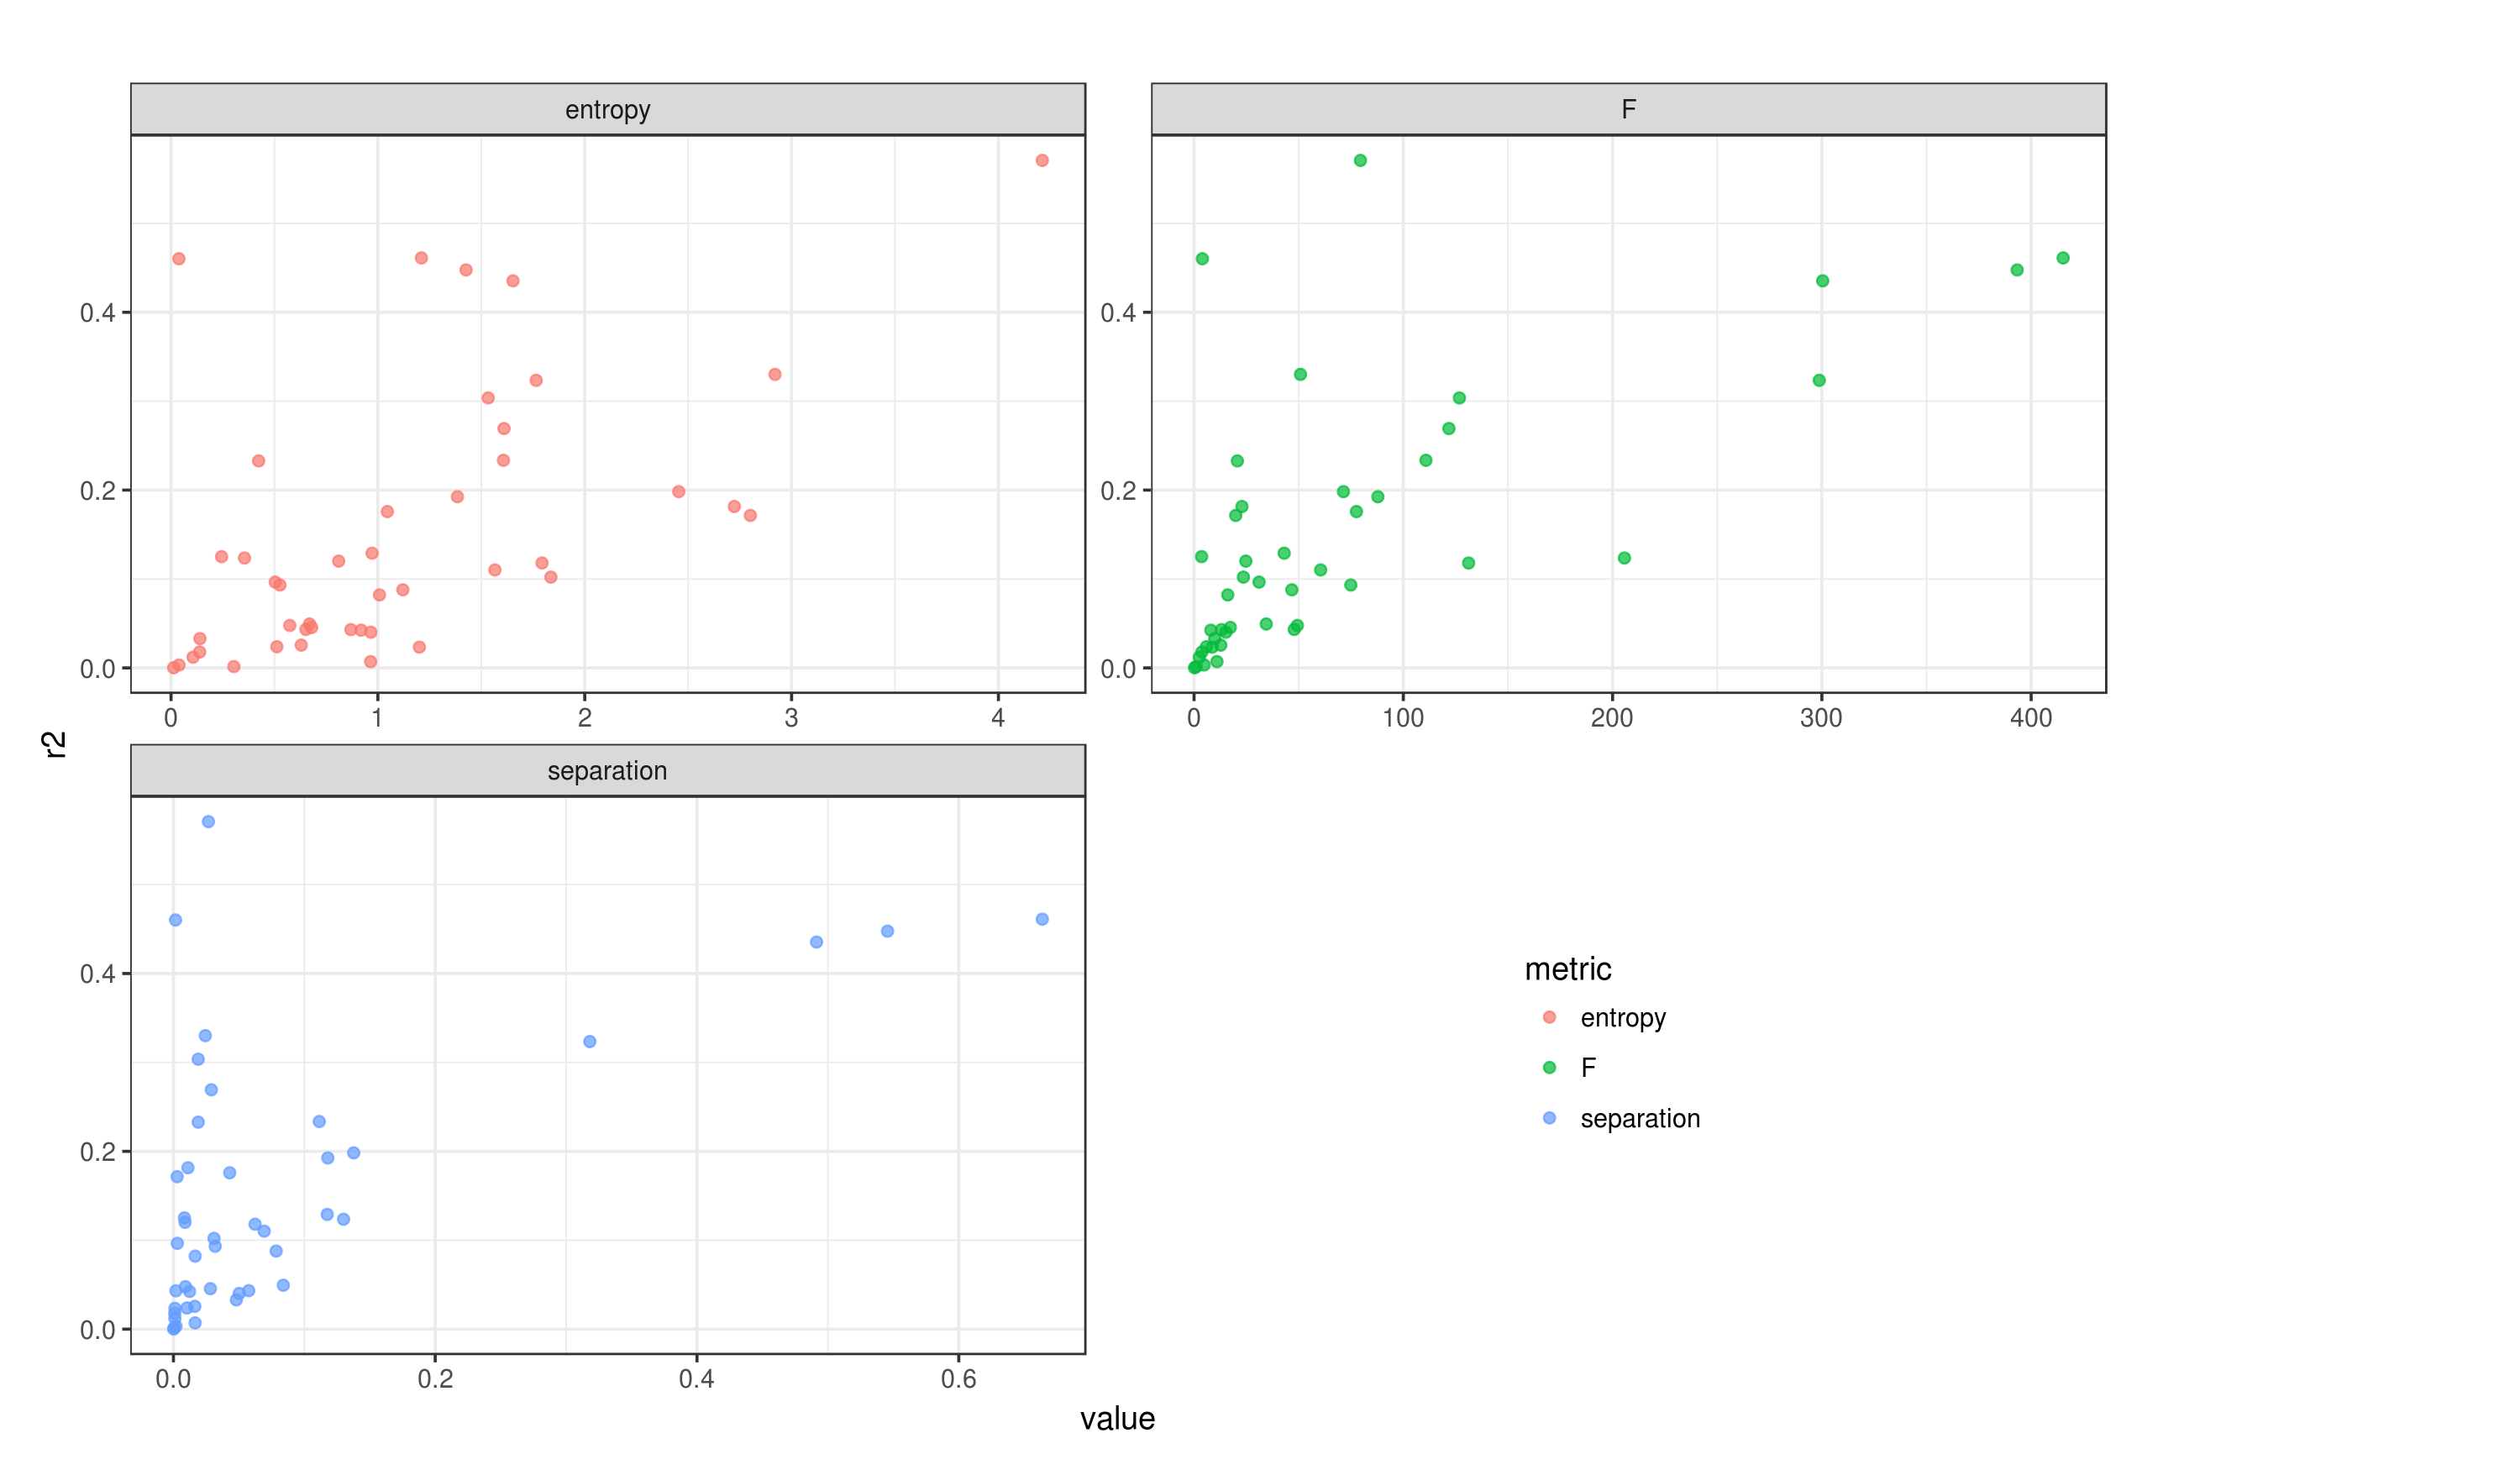

In [157]:
`@@@`(12, 7, 250)
together %>% 
filter(type == "Categorical") %>%
select(-type, -value_normed) %>%
spread(metric, value) %>%
gather(metric, value, -var, -r2) %>%
ggplot(aes(x=value, y=r2, color=metric)) +
geom_point(alpha = 0.7) +
facet_wrap(~metric, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position = "right", plot.title = element_text(hjust = 0.5)) +
theme(legend.position = c(0.75, 0.25)) +
theme(plot.margin = unit(c(1, 5, 0.5, 0.5), "cm"))

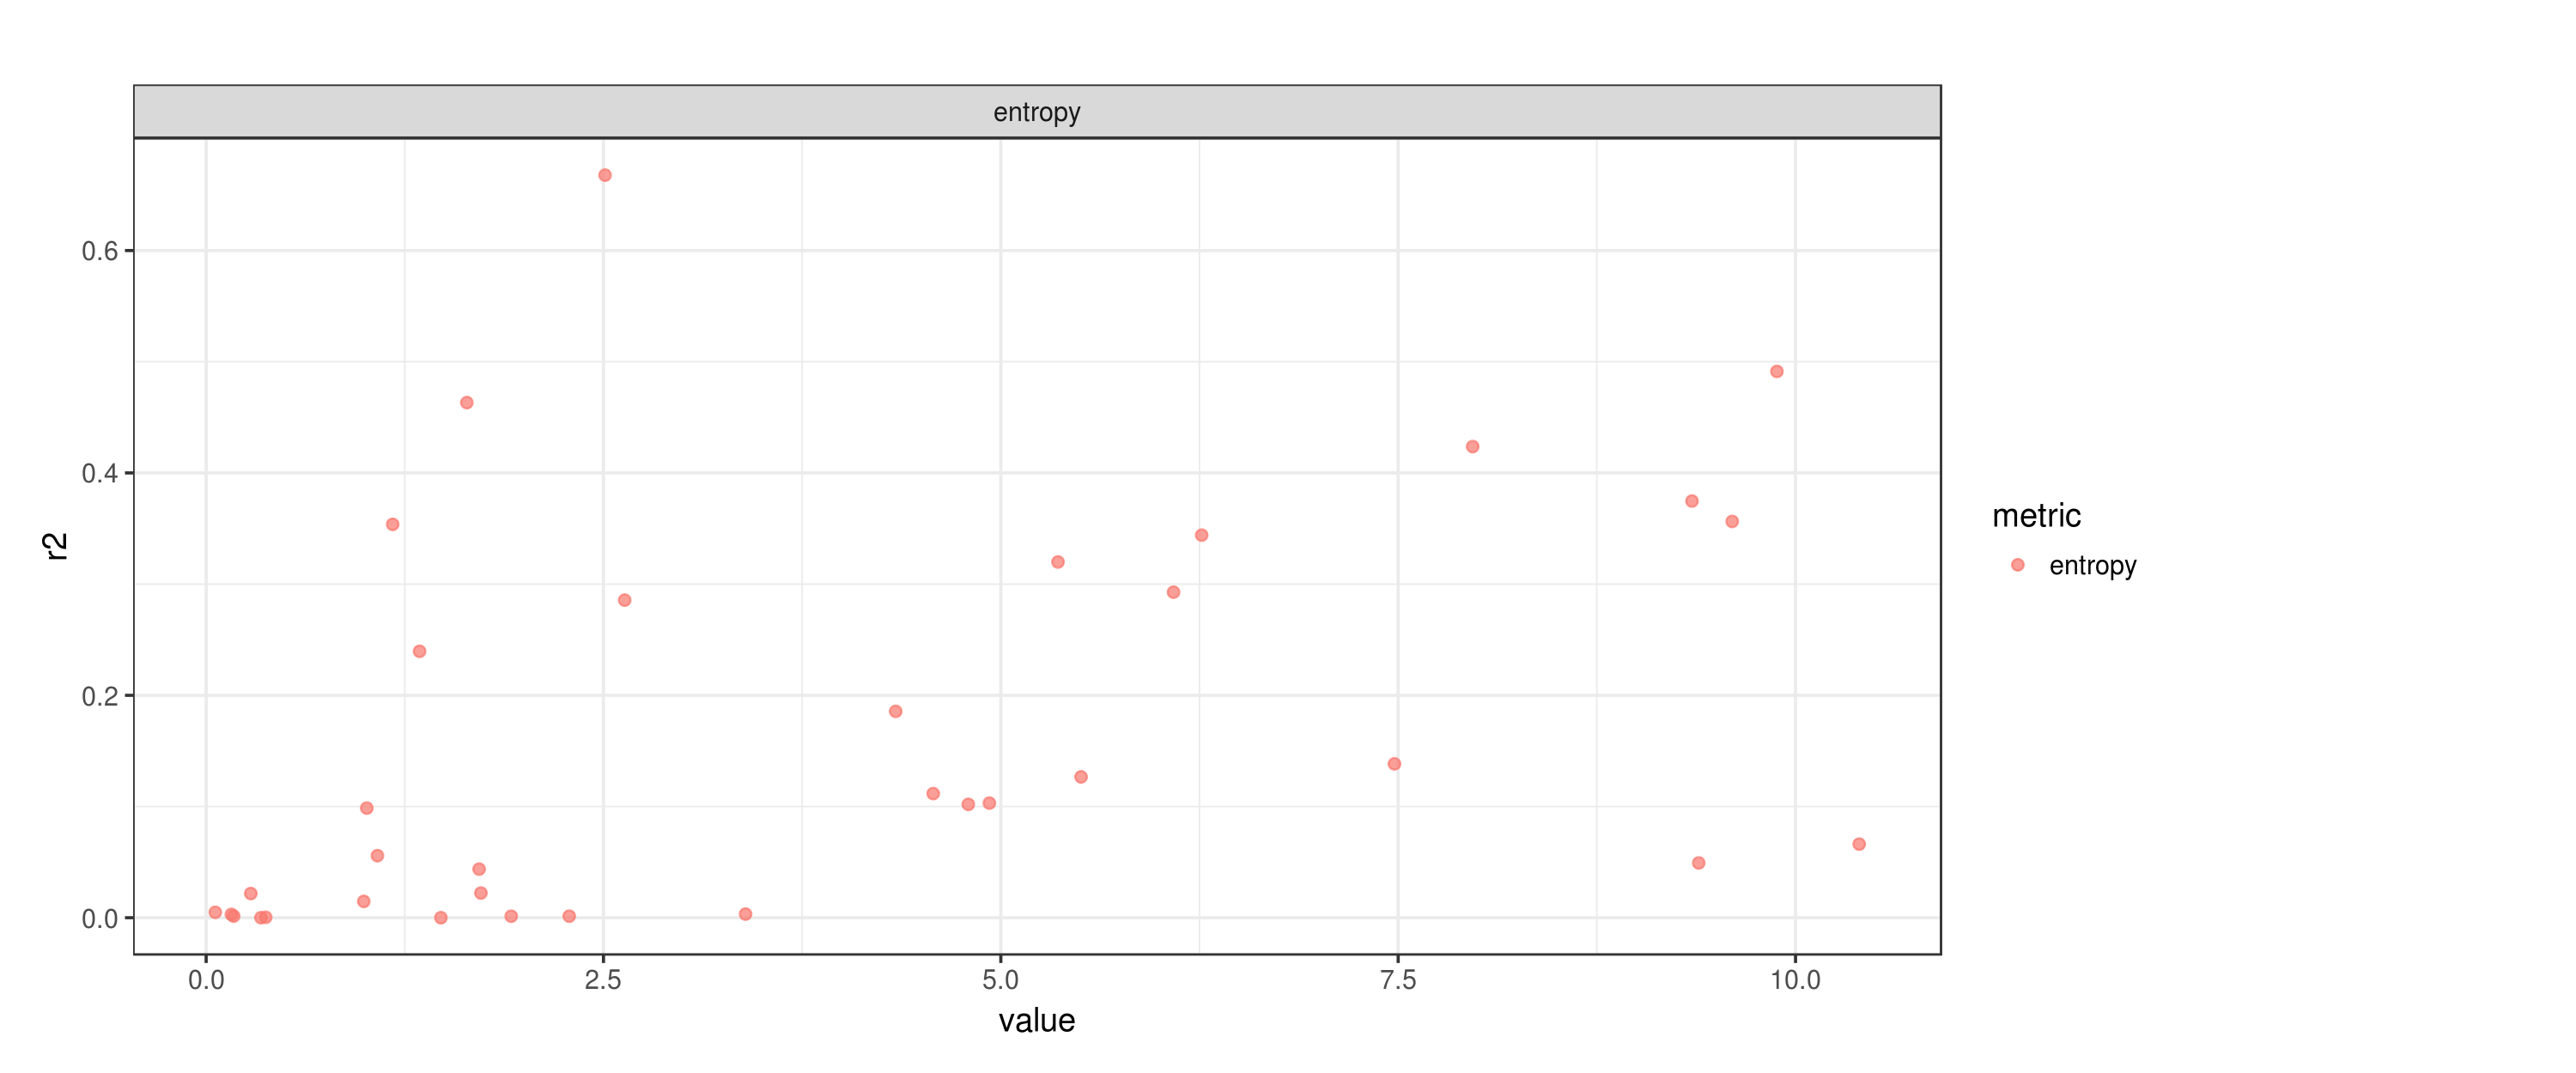

In [162]:
`@@@`(12, 5, 250)
together %>% 
filter(type == "Numeric") %>%
select(-type, -value_normed) %>%
spread(metric, value) %>%
gather(metric, value, -var, -r2) %>%
ggplot(aes(x=value, y=r2, color=metric)) +
geom_point(alpha = 0.7) +
facet_wrap(~metric, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position = "right", plot.title = element_text(hjust = 0.5)) +
theme(plot.margin = unit(c(1, 5, 0.5, 0.5), "cm"))

# Treemap of categorical predictors

ggplot2 plugin treemapify(which btw looks very pretty) is saddly buggy, thus another tree map library is used.

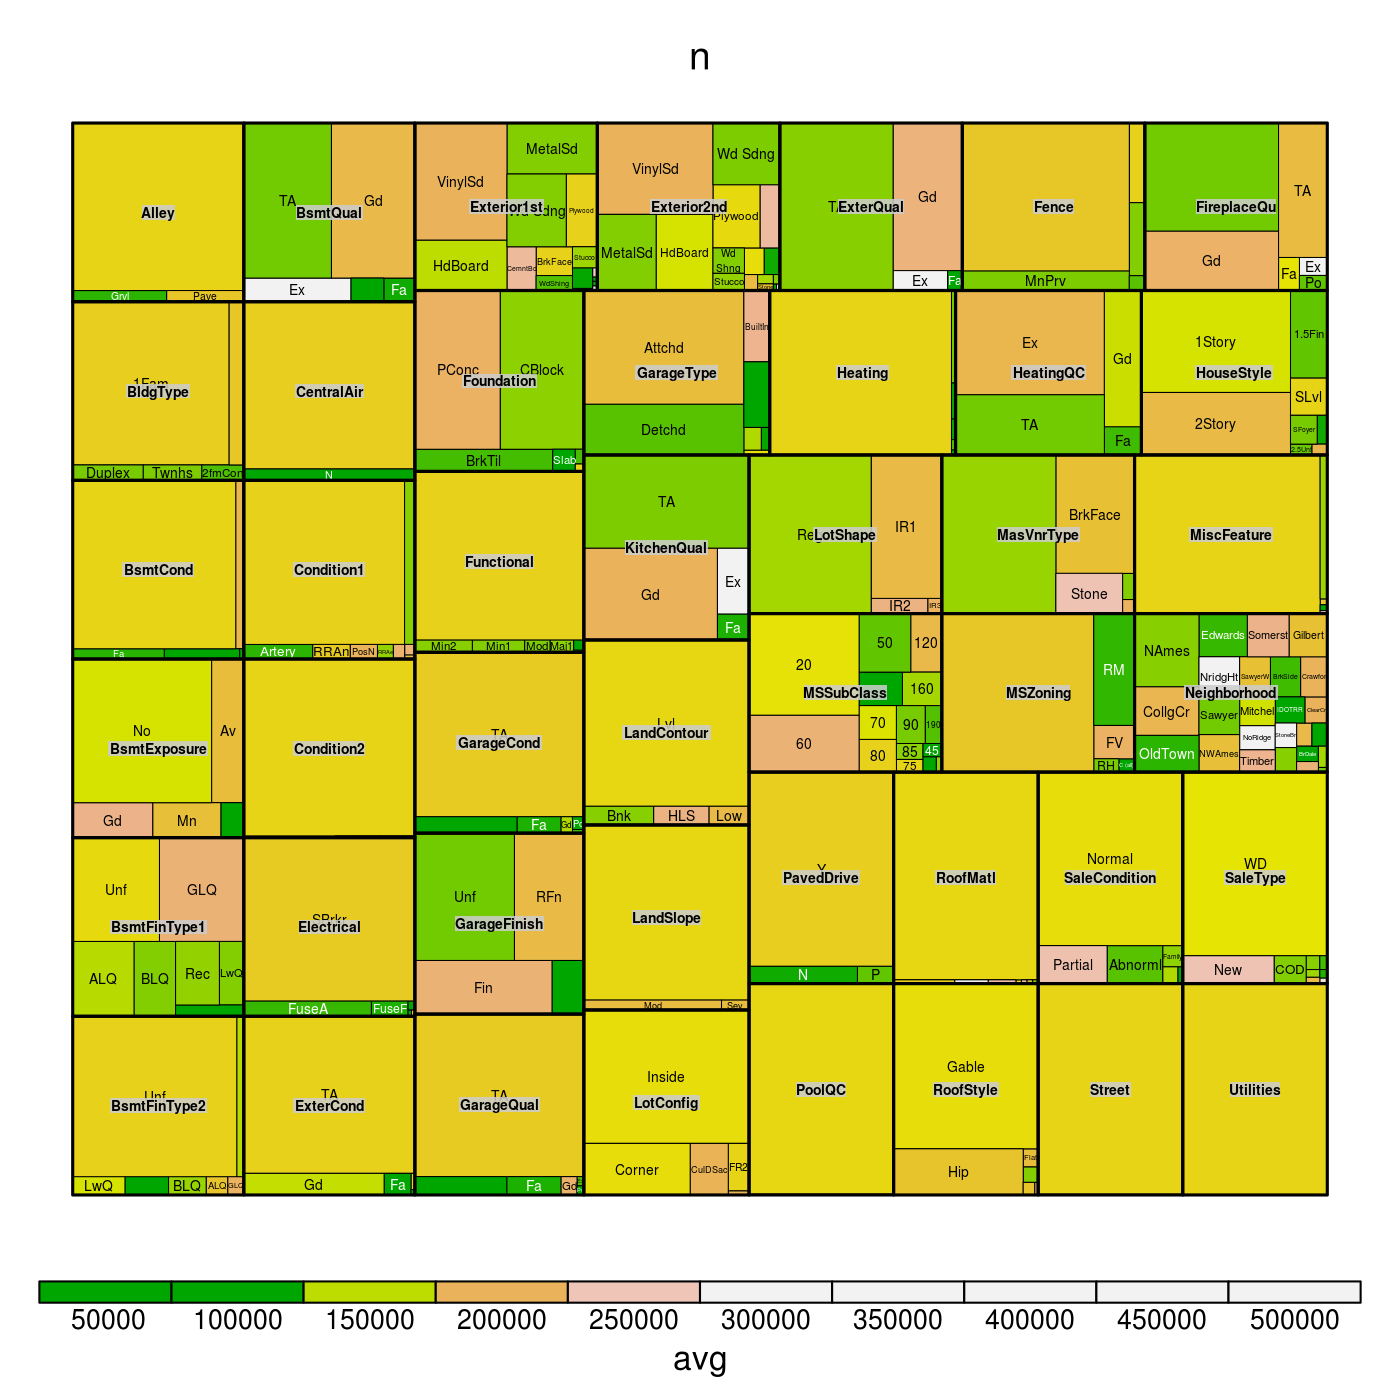

In [108]:
library(treemap, warn.conflicts=FALSE, quietly=TRUE)

df_for_treemap <-
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select(house_prices$helpers$get_character_colnames(combinedData), SalePrice) %>%
    gather(var, value, -SalePrice) %>%
    group_by(var, value) %>%
    summarise(
        avg = median(SalePrice),
        n = n()
    )

price <- 
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select(SalePrice) %>%
    `[[`(1)

`@@@`(7, 7, 200)
treemap(df_for_treemap,
       index=c("var", "value"),
       vSize="n",
       vColor="avg",
       type="value",
       palette=terrain.colors(10),
       mapping=quantile(price, c(0.1, 0.5, 0.9)),
       fontsize.labels = 5,
       border.lwds = c(1.5, 0.5))

# Scatterplots of numerical predictors
## $log(SalePrice) \sim log(predictor + 1)$

In [ ]:
df_for_ggplot <-
    combinedData %>%
    filter(!is.na(SalePrice)) %>%
    select_if(is.numeric) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id) %>%
    gather(var, value, -price_log) %>%
    replace_na(list(value = 0)) %>%
    mutate(
        value = log(value + 1),
        weak = var %in% attr_sel$useless_numeric_vars
    )

In [ ]:
`@@@`(15, 25, 140)
df_for_ggplot %>%
filter(weak) %>%
ggplot(aes(value, price_log)) +
geom_count(alpha = 0.4, color='#dc4e41') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5, size=20)) +
labs(title = "Probably they are useless")

In [ ]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no < 9) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

In [ ]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no >= 9, group_no < 17) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

In [ ]:
`@@@`(15, 20, 140)
df_for_ggplot %>%
filter(!weak) %>%
mutate(
    group_no = group_indices(., var)
) %>% 
filter(group_no >= 17) %>%
ggplot(aes(value, price_log)) +
geom_point(alpha = 0.4, color='steelblue') +
facet_wrap(~var, ncol = 2, scale='free') +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

Looks like `MoSold` and `YrSold` will be doing better as categorical factors